In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import datetime

from scipy import stats

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import classification_report, recall_score, precision_score


### Load and overview the data

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,Unnamed: 0,3D Authenticated,3D Offered,Browser,CVM Performed,CVM Result,Creation Date,Currency,DCC Accepted,Delivery Date,...,Avg_order_freq,Avg_IP_distance,avg_grad,avg_diff_grad,mean,std_dev,varience,skew,LABEL Status,LABEL Fraud Scoring
0,0,Y,Y,Safari,NaN,NaN,2016-12-01 16:54:37,EUR,NaN,NaN,...,0.0,5382.179047,0.000000,0.0,259.000000,0.000000,0.000000,0.00000,Authorised,25
1,1,A,Y,Chrome,NaN,NaN,2016-12-01 16:54:11,EUR,NaN,NaN,...,46.0,4176.131101,1.869565,0.0,168.033478,20.480061,438.498024,-0.63901,Cancelled,189
2,2,Y,Y,FireFox,NaN,NaN,2016-12-01 16:52:51,EUR,NaN,NaN,...,0.0,0.000000,0.000000,0.0,177.000000,0.000000,0.000000,0.00000,Authorised,25
3,3,Y,Y,Safari,NaN,NaN,2016-12-01 16:52:46,EUR,NaN,NaN,...,0.0,0.000000,0.000000,0.0,307.000000,0.000000,0.000000,0.00000,Authorised,25
4,4,Y,Y,IE11,NaN,NaN,2016-12-01 16:52:21,EUR,NaN,NaN,...,0.0,0.000000,0.000000,0.0,129.000000,0.000000,0.000000,0.00000,Authorised,25


In [4]:
print("The dataset has the shape of {} and the following columns:\n".format(data.shape))
for i in data.columns:
    print(i)

The dataset has the shape of (7673, 35) and the following columns:

Unnamed: 0
3D Authenticated
3D Offered
Browser
CVM Performed
CVM Result
Creation Date
Currency
DCC Accepted
Delivery Date
Device type
Entry Mode
Event
Issuer Country
Liability Indicator
Payment Method
Shopper Country
Shopper IP
Shopper Interaction
TimeZone
User Name
Value
ver_email
ver_phone
Avg_order_time
Avg_order_freq
Avg_IP_distance
avg_grad
avg_diff_grad
mean
std_dev
varience
skew
LABEL Status
LABEL Fraud Scoring


In [5]:
# data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7673 entries, 0 to 7672
Data columns (total 35 columns):
Unnamed: 0             7673 non-null int64
3D Authenticated       6720 non-null object
3D Offered             6801 non-null object
Browser                972 non-null object
CVM Performed          0 non-null float64
CVM Result             0 non-null float64
Creation Date          7673 non-null object
Currency               7673 non-null object
DCC Accepted           0 non-null float64
Delivery Date          0 non-null float64
Device type            972 non-null object
Entry Mode             0 non-null float64
Event                  0 non-null float64
Issuer Country         7673 non-null object
Liability Indicator    960 non-null object
Payment Method         7673 non-null object
Shopper Country        7673 non-null object
Shopper IP             7509 non-null object
Shopper Interaction    1000 non-null object
TimeZone               7673 non-null object
User Name              1000 n

In [6]:
print("The data has {} rows, and 'Unnamed: 0' has {} unique values".format(data.shape[0], data['Unnamed: 0'].value_counts().shape[0]))

The data has 7673 rows, and 'Unnamed: 0' has 7673 unique values


In [7]:
# rename "Unnamed: 0" to id, and "varience" to "variance"
data.columns = ['id', '3D Authenticated', '3D Offered', 'Browser',
       'CVM Performed', 'CVM Result', 'Creation Date', 'Currency',
       'DCC Accepted', 'Delivery Date', 'Device type', 'Entry Mode', 'Event',
       'Issuer Country', 'Liability Indicator', 'Payment Method',
       'Shopper Country', 'Shopper IP', 'Shopper Interaction', 'TimeZone',
       'User Name', 'Value', 'ver_email', 'ver_phone', 'Avg_order_time',
       'Avg_order_freq', 'Avg_IP_distance', 'avg_grad', 'avg_diff_grad',
       'mean', 'std_dev', 'variance', 'skew', 'LABEL Status',
       'LABEL Fraud Scoring']

In [8]:
# save id
data_id = data['id']

In [9]:
# from the info of the data, it is clear that there are columns that standout as having 0 non-values or 7673 null-values
print("example, the column 'CVM Performed' has {} null-values".format(data['CVM Performed'].isnull().sum()))

# drop all null-values columns along with the 'id' column
data.drop(['id','CVM Performed','CVM Result','DCC Accepted','Delivery Date','Entry Mode','Event'], axis=1, inplace=True)
print("The following columns have been succesfully dropped from the dataset: {}".format(['id','CVM Performed','CVM Result','DCC Accepted','Delivery Date','Entry Mode','Event']))

example, the column 'CVM Performed' has 7673 null-values
The following columns have been succesfully dropped from the dataset: ['id', 'CVM Performed', 'CVM Result', 'DCC Accepted', 'Delivery Date', 'Entry Mode', 'Event']


In [10]:
# convert "LABEL Fraud Scoring" type from integer to float
data['LABEL Fraud Scoring'] = data['LABEL Fraud Scoring'].astype('float64')

### Categorical features

Let's examine categorical features

In [11]:
data.select_dtypes(exclude=['number']).head()

,3D Authenticated,3D Offered,Browser,Creation Date,Currency,Device type,Issuer Country,Liability Indicator,Payment Method,Shopper Country,Shopper IP,Shopper Interaction,TimeZone,User Name,LABEL Status
0,Y,Y,Safari,2016-12-01 16:54:37,EUR,Other,FR,Y,cartebancaire,FR,88.168.245.32,Ecommerce,CET,ws@Company.BackMarket,Authorised
1,A,Y,Chrome,2016-12-01 16:54:11,EUR,Other,BE,Y,mc,BE,91.176.162.85,Ecommerce,CET,ws@Company.BackMarket,Cancelled
2,Y,Y,FireFox,2016-12-01 16:52:51,EUR,Other,CH,Y,visa,CH,145.232.108.212,Ecommerce,CET,ws@Company.BackMarket,Authorised
3,Y,Y,Safari,2016-12-01 16:52:46,EUR,iPad,FR,Y,cartebancaire,FR,176.132.222.71,Ecommerce,CET,ws@Company.BackMarket,Authorised
4,Y,Y,IE11,2016-12-01 16:52:21,EUR,Other,FR,Y,cartebancaire,FR,79.92.249.94,Ecommerce,CET,ws@Company.BackMarket,Authorised


In [12]:
# explore cardinality of each categorical feature
for col in data.select_dtypes(exclude=['number']).drop(['Creation Date','User Name'],axis=1).columns:
    print('The unique values of {} are {}'.format(col,data[col].unique()))

The unique values of 3D Authenticated are ['Y' 'A' 'N' nan 'U']
The unique values of 3D Offered are ['Y' nan 'N' '-']
The unique values of Browser are ['Safari' 'Chrome' 'FireFox' 'IE11' nan 'Edge14' 'IE10' 'Other' 'Edge13']
The unique values of Currency are ['EUR']
The unique values of Device type are ['Other' 'iPad' 'Android Mobile' 'Android Tablet' nan 'iPhone']
The unique values of Issuer Country are ['FR' 'BE' 'CH' '(unknown)' 'ES' 'LU' 'DK' 'DE' 'CA' 'IT' 'GB' 'US' 'MY'
 'TH' 'NO' 'NP' 'IL' 'PT' 'AT' 'RO' 'AU' 'HK' 'MW' 'IS' 'GR' 'LB' 'HU' 'JP'
 'SK' 'SE' 'NL' 'AR' 'PH' 'CG' 'MX' 'SG' 'AE']
The unique values of Liability Indicator are ['Y' 'N' nan]
The unique values of Payment Method are ['cartebancaire' 'mc' 'visa' 'unknowncard' 'bcmc' 'visadankort'
 'bankTransfer_IBAN' 'bankTransfer_DE' 'directEbanking' 'amex' 'uatp'
 'maestro' 'bankTransfer_BE']
The unique values of Shopper Country are ['FR' 'BE' 'CH' 'ES' '(unknown)' 'CA' 'DE' 'IT' 'GB' 'GF' 'NL' 'DK' 'KH'
 'GP' 'IE' 'RE' 'YT

In [13]:
# "Currency" and "Timezone" are constants, we can proceed to drop them
data.drop(['Currency','TimeZone'],axis=1,inplace=True)

In [14]:
# explore "creation date"
data['Creation Date'] = pd.to_datetime(data['Creation Date'],format='%Y-%m-%d %H:%M:%S')

In [15]:
data['YMD'] = data['Creation Date'].apply(lambda x: datetime.strftime(x,"%Y-%m-%d"))
data['months'] = data['Creation Date'].apply(lambda x: datetime.strftime(x,"%B"))
data['days'] =  data['Creation Date'].apply(lambda x: datetime.strftime(x,"%a"))
data['Hours'] = data['Creation Date'].apply(lambda x: datetime.strftime(x,"%H"))

In [16]:
# feature YearMonthDay
data['YMD'].value_counts()

2016-12-07    1287
2016-12-03     944
2016-12-02     879
2016-12-05     870
2016-11-29     750
2016-12-01     608
2016-11-17     573
2016-11-30     502
2016-12-08     341
2016-12-06     288
2016-11-28     250
2016-11-18     218
2016-12-04     127
2016-11-04      21
2016-11-07       5
2016-11-16       3
2016-11-03       3
2016-11-14       2
2016-11-08       2
Name: YMD, dtype: int64

In [17]:
# feature months
data['months'].value_counts()

December    5344
November    2329
Name: months, dtype: int64

In [18]:
# feature days
data['days'].value_counts()

Wed    1792
Thu    1525
Mon    1127
Fri    1118
Tue    1040
Sat     944
Sun     127
Name: days, dtype: int64

In [19]:
# feature hours
data['Hours'].value_counts()

21    698
22    587
20    505
12    493
19    492
13    490
11    460
18    457
10    442
14    416
17    415
15    396
09    379
16    363
23    332
08    225
00    146
07     94
01     84
02     52
06     45
04     38
05     38
03     26
Name: Hours, dtype: int64

In [20]:
# function to group hours in three segments of the day: Morning, Afternoon and evening. The two features could be used separately
def timesection(x):
    x = int(x)
    if  x< 12:
        return 'morning'
    elif x >= 12 and x < 18:
        return 'afternoon'
    elif x >= 18 and x<24:
        return 'evening'

In [21]:
data['time_section'] = data['Hours'].apply(timesection)
data['time_section'].value_counts()

evening      3071
afternoon    2573
morning      2029
Name: time_section, dtype: int64

In [22]:
# drop the creation date
data.drop('Creation Date',axis=1,inplace=True)

In [23]:
# print the new categorical features along with old ones
data.select_dtypes(exclude=['number']).head().columns

Index(['3D Authenticated', '3D Offered', 'Browser', 'Device type',
       'Issuer Country', 'Liability Indicator', 'Payment Method',
       'Shopper Country', 'Shopper IP', 'Shopper Interaction', 'User Name',
       'LABEL Status', 'YMD', 'months', 'days', 'Hours', 'time_section'],
      dtype='object')

#### Missing values for categorical features

In [24]:
# categorical features with missing values
for col in data.select_dtypes(exclude=['number']).columns:
    print('{} is {}'.format(col, data[col].isnull().sum()))

3D Authenticated is 953
3D Offered is 872
Browser is 6701
Device type is 6701
Issuer Country is 0
Liability Indicator is 6713
Payment Method is 0
Shopper Country is 0
Shopper IP is 164
Shopper Interaction is 6673
User Name is 6673
LABEL Status is 0
YMD is 0
months is 0
days is 0
Hours is 0
time_section is 0


In [25]:
# check number of missing values through columns
data.select_dtypes(exclude=['number']).isnull().sum(axis=1).value_counts()

5    5868
0     852
7     594
8     136
6     103
2     102
3      12
1       6
dtype: int64

In [26]:
# check number of missing values through rows
data.select_dtypes(exclude=['number']).isnull().sum(axis=0).value_counts()

0       9
6673    2
6701    2
953     1
6713    1
872     1
164     1
dtype: int64

In [27]:
# select columns wiht more than 6000 missing rows and check if missing values are on the same rows
data[['Liability Indicator','Browser','Device type','Shopper Interaction','User Name']].isnull().sum(axis=1).value_counts()

5    6673
0     960
3      28
1      12
dtype: int64

In [28]:
data[['Liability Indicator','Browser','Device type','Shopper Interaction','User Name']].isnull().sum(axis=0).value_counts()

6701    2
6673    2
6713    1
dtype: int64

In [29]:
# it is clear that the selected columns have not only high number of missing values in solo, but they share the same rows in missing those values, it is safe to drop them all
data.drop(['Liability Indicator','Browser','Device type','Shopper Interaction','User Name'],axis=1, inplace=True)

In [30]:
# second check for missing values
for col in data.select_dtypes(exclude=['number']).columns:
    print('{} is {}'.format(col, data[col].isnull().sum()))

3D Authenticated is 953
3D Offered is 872
Issuer Country is 0
Payment Method is 0
Shopper Country is 0
Shopper IP is 164
LABEL Status is 0
YMD is 0
months is 0
days is 0
Hours is 0
time_section is 0


In [31]:
# 1000/data.shape[0]*100 // percent of missing values for "3D Authenticated" and "3D Offered"

Note: the features "3D Authenticated" and "3D Offered" are missing less than 1000 which represents **13%** of the total dataset, we will proceed by *imputing values* for these features


In [32]:
# "Shopper IP" has only 164 values, but let's inspect its cardinality
print("The cardinality of 'Shopper IP' represents {:.2f} of  the total dataset".format(data['Shopper IP'].value_counts().shape[0]/data.shape[0]*100))

The cardinality of 'Shopper IP' represents 68.21 of  the total dataset


In [33]:
# Top 5 values count for shopper IP
data['Shopper IP'].value_counts()[:5]

10.246.12.115    366
10.246.11.6      346
109.12.216.86     25
10.246.10.8       25
81.56.57.113      23
Name: Shopper IP, dtype: int64

In [34]:
# Shopper IP has very large cardinality and for this case we will drop it from the dataset
data.drop('Shopper IP', axis=1, inplace=True)

*'3D Authenticated' and '3D Offered'*

In [35]:
data['3D Authenticated'].value_counts()

Y    5922
N     705
A      76
U      17
Name: 3D Authenticated, dtype: int64

In [36]:
data['3D Authenticated'].isnull().sum()

953

In [37]:
data['3D Authenticated'] = data['3D Authenticated'].fillna('U')

In [38]:
data['3D Authenticated'].value_counts()

Y    5922
U     970
N     705
A      76
Name: 3D Authenticated, dtype: int64

In [39]:
data['3D Offered'].value_counts()

Y    6720
N      72
-       9
Name: 3D Offered, dtype: int64

In [40]:
data['3D Offered'].isnull().sum()
# to do, combinae - and nan in U

872

In [41]:
data['3D Offered'] = data['3D Offered'].fillna('U')

In [42]:
off3d = {'Y':'Y','N':'N','-':'U','U':'U'}
data['3D Offered'] = data['3D Offered'].map(off3d)

In [43]:
data['3D Offered'].value_counts()

Y    6720
U     881
N      72
Name: 3D Offered, dtype: int64

*'Issuer Country' and 'Shopper Country'*

In [44]:
data['Issuer Country'].value_counts()[:5]

FR           6717
ES            502
DE            123
BE            101
(unknown)      80
Name: Issuer Country, dtype: int64

In [45]:
countrydict = {'FR':'FR','ES':'ES','DE':'DE','BE':'BE'}

In [46]:
data['Issuer Country'] = data['Issuer Country'].map(countrydict)
data['Issuer Country'].fillna('other', inplace=True)

In [47]:
data['Issuer Country'].value_counts()

FR       6717
ES        502
other     230
DE        123
BE        101
Name: Issuer Country, dtype: int64

In [48]:
data['Shopper Country'].value_counts()[:5]

FR           5886
(unknown)     995
ES            446
DE            115
BE            104
Name: Shopper Country, dtype: int64

In [49]:
data['Shopper Country'] = data['Shopper Country'].map(countrydict)
data['Shopper Country'].fillna('other', inplace=True)

In [50]:
data['Shopper Country'].value_counts()

FR       5886
other    1122
ES        446
DE        115
BE        104
Name: Shopper Country, dtype: int64

In [51]:
# create a new feature that returns 1 if Shopper Country and Issuer Country are the same, and returns 0 otherwise
def cnt(x):
    if x['Shopper Country'] == x['Issuer Country']:
        return 1
    else:
        return 0

In [52]:
data['count_simdif'] = data.apply(cnt,axis=1)

In [53]:
data['count_simdif'].value_counts()

1    6408
0    1265
Name: count_simdif, dtype: int64

In [54]:
for col in data.select_dtypes(exclude=['number']).columns:
    print('The unique values of {} are {}'.format(col,data[col].unique()))

The unique values of 3D Authenticated are ['Y' 'A' 'N' 'U']
The unique values of 3D Offered are ['Y' 'U' 'N']
The unique values of Issuer Country are ['FR' 'BE' 'other' 'ES' 'DE']
The unique values of Payment Method are ['cartebancaire' 'mc' 'visa' 'unknowncard' 'bcmc' 'visadankort'
 'bankTransfer_IBAN' 'bankTransfer_DE' 'directEbanking' 'amex' 'uatp'
 'maestro' 'bankTransfer_BE']
The unique values of Shopper Country are ['FR' 'BE' 'other' 'ES' 'DE']
The unique values of LABEL Status are ['Authorised' 'Cancelled' 'Refused' 'SentForSettle' 'Refunded'
 'SettledBulk' 'Settled' 'SentForRefund' 'RefundedBulk' 'Expired']
The unique values of YMD are ['2016-12-01' '2016-11-30' '2016-12-08' '2016-12-07' '2016-12-04'
 '2016-12-03' '2016-12-06' '2016-12-05' '2016-11-18' '2016-11-17'
 '2016-11-16' '2016-11-14' '2016-11-08' '2016-11-07' '2016-11-04'
 '2016-11-03' '2016-12-02' '2016-11-29' '2016-11-28']
The unique values of months are ['December' 'November']
The unique values of days are ['Thu' 'We

## Continuous features

In [55]:
data.select_dtypes(include=['number'])

,Value,ver_email,ver_phone,Avg_order_time,Avg_order_freq,Avg_IP_distance,avg_grad,avg_diff_grad,mean,std_dev,variance,skew,LABEL Fraud Scoring,count_simdif
0,283.59,1.0,1.0,0.000000,0.000000,5382.179047,0.000000,0.000000,259.000000,0.000000,0.000000,0.000000e+00,25.0,1
1,197.99,1.0,1.0,914.421970,46.000000,4176.131101,1.869565,0.000000,168.033478,20.480061,438.498024,-6.390097e-01,189.0,1
2,183.90,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,177.000000,0.000000,0.000000,0.000000e+00,25.0,1
3,312.00,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,307.000000,0.000000,0.000000,0.000000e+00,25.0,1
4,135.90,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,129.000000,0.000000,0.000000,0.000000e+00,25.0,1
5,449.90,1.0,1.0,0.000000,0.000000,4870.473650,0.000000,0.000000,443.000000,0.000000,0.000000,0.000000e+00,25.0,1
6,312.00,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,307.000000,0.000000,0.000000,0.000000e+00,25.0,1
7,290.89,1.0,1.0,2954.733333,1.000000,0.000000,130.000000,0.000000,334.000000,65.000000,8450.000000,0.000000e+00,25.0,1
8,644.00,1.0,1.0,169.585000,110.000000,0.000000,30.777778,0.000000,641.444444,163.614799,30116.027778,-1.636006e-01,56.0,1
9,121.69,1.0,1.0,63910.138889,0.090226,0.000000,-28.465000,12.633333,147.970000,40.274454,2162.708867,3.131668e-01,0.0,1


In [56]:
data.select_dtypes(include=['number']).describe()

,Value,ver_email,ver_phone,Avg_order_time,Avg_order_freq,Avg_IP_distance,avg_grad,avg_diff_grad,mean,std_dev,variance,skew,LABEL Fraud Scoring,count_simdif
count,7673.000000,7390.0,7390.000000,7.390000e+03,7390.000000,7390.000000,7390.000000,7390.000000,7390.000000,7390.000000,7.390000e+03,7390.000000,7673.000000,7673.000000
mean,372.674346,1.0,0.993505,1.476676e+04,inf,1748.716148,-0.937261,-0.813153,325.679474,26.103044,1.063213e+04,0.012676,36.904470,0.835136
std,2426.298503,0.0,0.080336,5.882005e+04,NaN,2457.987603,55.910904,32.816874,202.647834,91.891793,1.303413e+05,0.675989,50.753829,0.371082
min,1.000000,1.0,0.000000,0.000000e+00,0.000000,0.000000,-938.000000,-625.505000,9.000000,0.000000,0.000000e+00,-4.321795,-190.000000,0.000000
25%,199.000000,1.0,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,199.000000,0.000000,0.000000e+00,0.000000,20.000000,1.000000
50%,308.000000,1.0,1.000000,3.394444e+00,0.195994,0.000000,0.000000,0.000000,300.630000,0.000000,0.000000e+00,0.000000,25.000000,1.000000
75%,408.900000,1.0,1.000000,8.263479e+02,inf,4967.630295,0.000000,0.000000,399.000000,9.046038,1.200000e+02,0.000000,35.000000,1.000000
max,150000.000000,1.0,1.000000,1.048504e+06,inf,9256.840424,1034.000000,458.252500,2976.000000,1970.173062,4.036845e+06,4.707155,774.000000,1.000000


First, "ver_email" and "ver_phone" seem to be constant, we will investigate that.We can observe that the "Avg_order_freq" has infinite values that need to be handled. in addition we see that some features have very extreme values which could suggest that they are skewed and may need a transformation

In [57]:
data['ver_email'].value_counts()

1.0    7390
Name: ver_email, dtype: int64

In [58]:
data['ver_phone'].value_counts()

1.0    7342
0.0      48
Name: ver_phone, dtype: int64

In [59]:
# drop ver_email and ver_phone
data.drop(['ver_email','ver_phone'],axis=1, inplace=True)

In [60]:
# continuous features with missing values
for col in data.select_dtypes(include=['number']).columns:
    print('{} is {}'.format(col, data[col].isnull().sum()))

Value is 0
Avg_order_time is 283
Avg_order_freq is 283
Avg_IP_distance is 283
avg_grad is 283
avg_diff_grad is 283
mean is 283
std_dev is 283
variance is 283
skew is 283
LABEL Fraud Scoring is 0
count_simdif is 0


In [61]:
# There are 9 features that show the same number of missing values, let's investigate it
nan_col = ['Avg_order_time','Avg_order_freq','Avg_IP_distance','avg_grad','avg_diff_grad','mean','std_dev','variance','skew']
data[nan_col].isnull().sum(axis=1).value_counts()

0    7390
9     283
dtype: int64

In [62]:
# collect the indices
nan_inx = pd.isnull(data[nan_col]).any(1).nonzero()[0]
pd.isnull(data[nan_col]).any(1).nonzero()[0].shape

(283,)

In [63]:
# drop the 283 rows that have missing values for the 9 features selected above
data.drop(data.index[nan_inx], inplace=True)

In [64]:
# Check that selected rows have been successfuly deleted
data[nan_col].isnull().sum(axis=1).value_counts()

0    7390
dtype: int64

In [65]:
# We observed in the describe of continuous values that one feature had infinite values, let's investigate it more
for col in data.select_dtypes(include=['number']).columns:
    print('{} is {}'.format(col, sum(data[col] == float('Inf'))))

Value is 0
Avg_order_time is 0
Avg_order_freq is 2194
Avg_IP_distance is 0
avg_grad is 0
avg_diff_grad is 0
mean is 0
std_dev is 0
variance is 0
skew is 0
LABEL Fraud Scoring is 0
count_simdif is 0


In [66]:
# check distribution of Label status for infinity values
data[data['Avg_order_freq'] == float('Inf')]['LABEL Status'].value_counts()

Refused          1072
Authorised        565
Settled           324
SentForSettle     124
SettledBulk        57
Cancelled          46
Expired             3
SentForRefund       2
Refunded            1
Name: LABEL Status, dtype: int64

In [67]:
# check distribution of Label Status for the second maximum value (the one before inifinite)
data[data['Avg_order_freq'] == data[data['Avg_order_freq'] != float('Inf')]['Avg_order_freq'].max()]['LABEL Status'].value_counts()

Refused    22
Settled     1
Name: LABEL Status, dtype: int64

In [68]:
# set infinity values to equal twice the maximum finite value
data.loc[data['Avg_order_freq'] == float('Inf'), 'Avg_order_freq'] = data[data['Avg_order_freq'] != float('Inf')]['Avg_order_freq'].max()*2

In [69]:
# Check that the assignment has been successful
for col in data.select_dtypes(include=['number']).columns:
    print('{} is {}'.format(col, sum(data[col] == float('Inf'))))

Value is 0
Avg_order_time is 0
Avg_order_freq is 0
Avg_IP_distance is 0
avg_grad is 0
avg_diff_grad is 0
mean is 0
std_dev is 0
variance is 0
skew is 0
LABEL Fraud Scoring is 0
count_simdif is 0


In [70]:
# Check if there are negative abnormal values
for col in data.select_dtypes(include=['number']).columns:
    print('{} is {}'.format(col, sum(data[col] <0)))

Value is 0
Avg_order_time is 0
Avg_order_freq is 0
Avg_IP_distance is 0
avg_grad is 1230
avg_diff_grad is 738
mean is 0
std_dev is 0
variance is 0
skew is 929
LABEL Fraud Scoring is 1
count_simdif is 0


In [71]:
# Since there is only one Label Fraud Scoring value that is negative, we will it assign it to zero
data.at[data[data['LABEL Fraud Scoring']<0].index[0],'LABEL Fraud Scoring'] = 0

In [72]:
# check that there are no missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7390 entries, 0 to 7672
Data columns (total 23 columns):
3D Authenticated       7390 non-null object
3D Offered             7390 non-null object
Issuer Country         7390 non-null object
Payment Method         7390 non-null object
Shopper Country        7390 non-null object
Value                  7390 non-null float64
Avg_order_time         7390 non-null float64
Avg_order_freq         7390 non-null float64
Avg_IP_distance        7390 non-null float64
avg_grad               7390 non-null float64
avg_diff_grad          7390 non-null float64
mean                   7390 non-null float64
std_dev                7390 non-null float64
variance               7390 non-null float64
skew                   7390 non-null float64
LABEL Status           7390 non-null object
LABEL Fraud Scoring    7390 non-null float64
YMD                    7390 non-null object
months                 7390 non-null object
days                   7390 non-null object
Ho

### Make a dataframe with dummy variables

In [73]:
# a function to return a dataframe with dummy variables for all categorical features
def makedummy(df, columns):
    df_copy = df.copy() # create a copy of original dataset to work on
    for col in columns:
        dum  = pd.get_dummies(df_copy[col], prefix=col)
        dum.drop(dum.columns[-1],axis=1,inplace=True) # drop the last column to avoid dummy trap
        df_copy = pd.concat([df_copy,dum],axis=1)
        df_copy.drop(col,axis=1,inplace=True) # drop the original column
    return df_copy # return final dummy dataframe

In [74]:
df_to_dummy  = data.select_dtypes(exclude=['number']).drop('LABEL Status',axis=1)
df_cat = makedummy(df_to_dummy,df_to_dummy.columns)

In [75]:
df_cat.head()

,3D Authenticated_A,3D Authenticated_N,3D Authenticated_U,3D Offered_N,3D Offered_U,Issuer Country_BE,Issuer Country_DE,Issuer Country_ES,Issuer Country_FR,Payment Method_amex,...,Hours_15,Hours_16,Hours_17,Hours_18,Hours_19,Hours_20,Hours_21,Hours_22,time_section_afternoon,time_section_evening
0,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
1,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0


### Univariate Analysis

#### Categorical

In [76]:
cols = data.select_dtypes(exclude=['number']).columns.tolist()

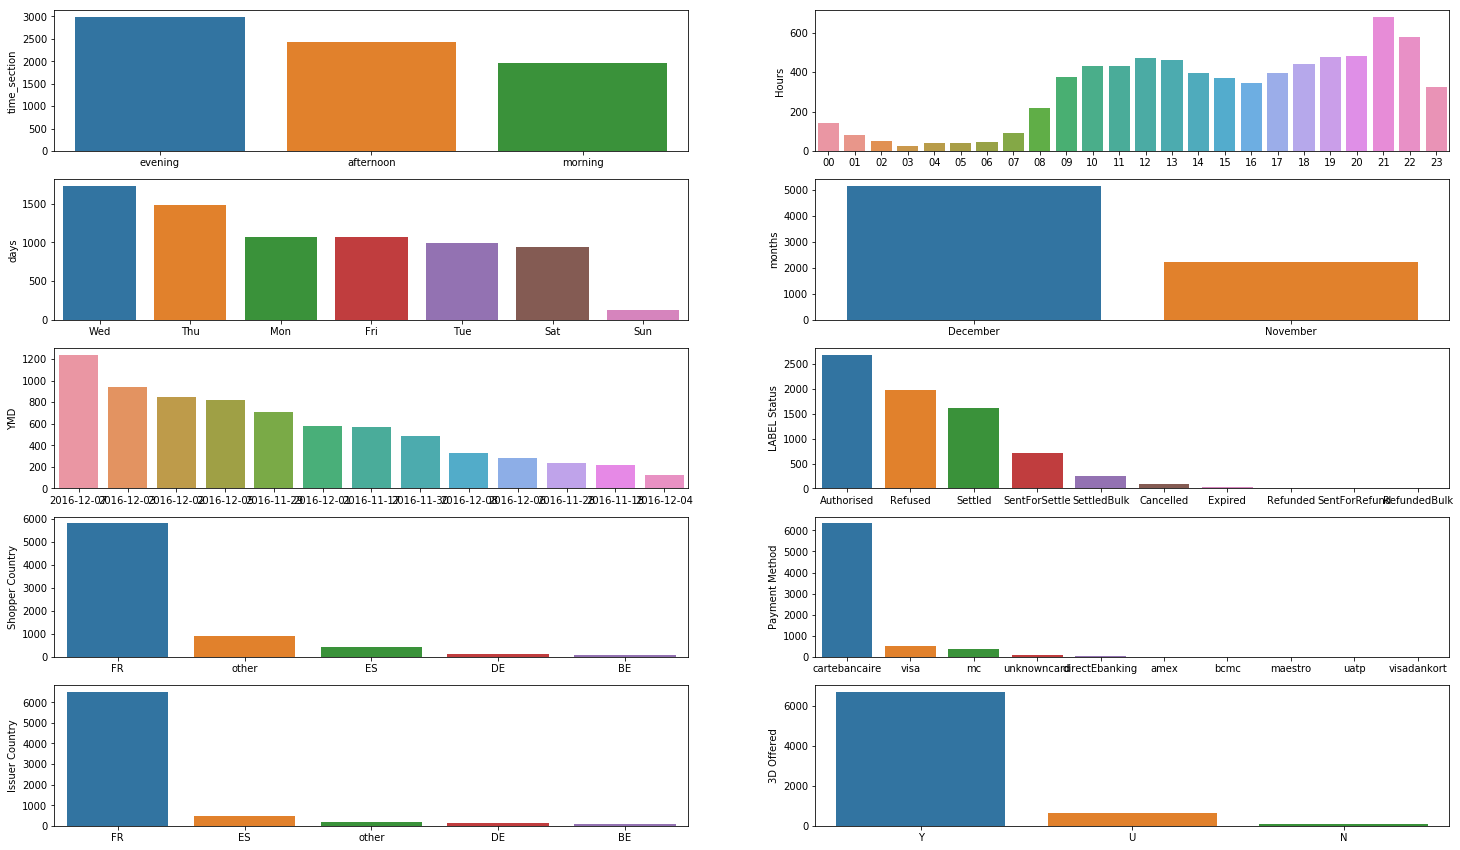

In [77]:
# plotting the count of every categorical variable
fig, ax = plt.subplots(5,2, figsize=(25,15))
cols = data.select_dtypes(exclude=['number']).columns.tolist()
for i in range(0,5):
    for j in range(0,2):
        if cols == []:
            break
        cc = cols[::-1]
        sns.barplot(y=data[cc[0]].value_counts(),x=data[cc[0]].value_counts().index,ax=ax[i,j])
        cols.pop()

#### Continuous

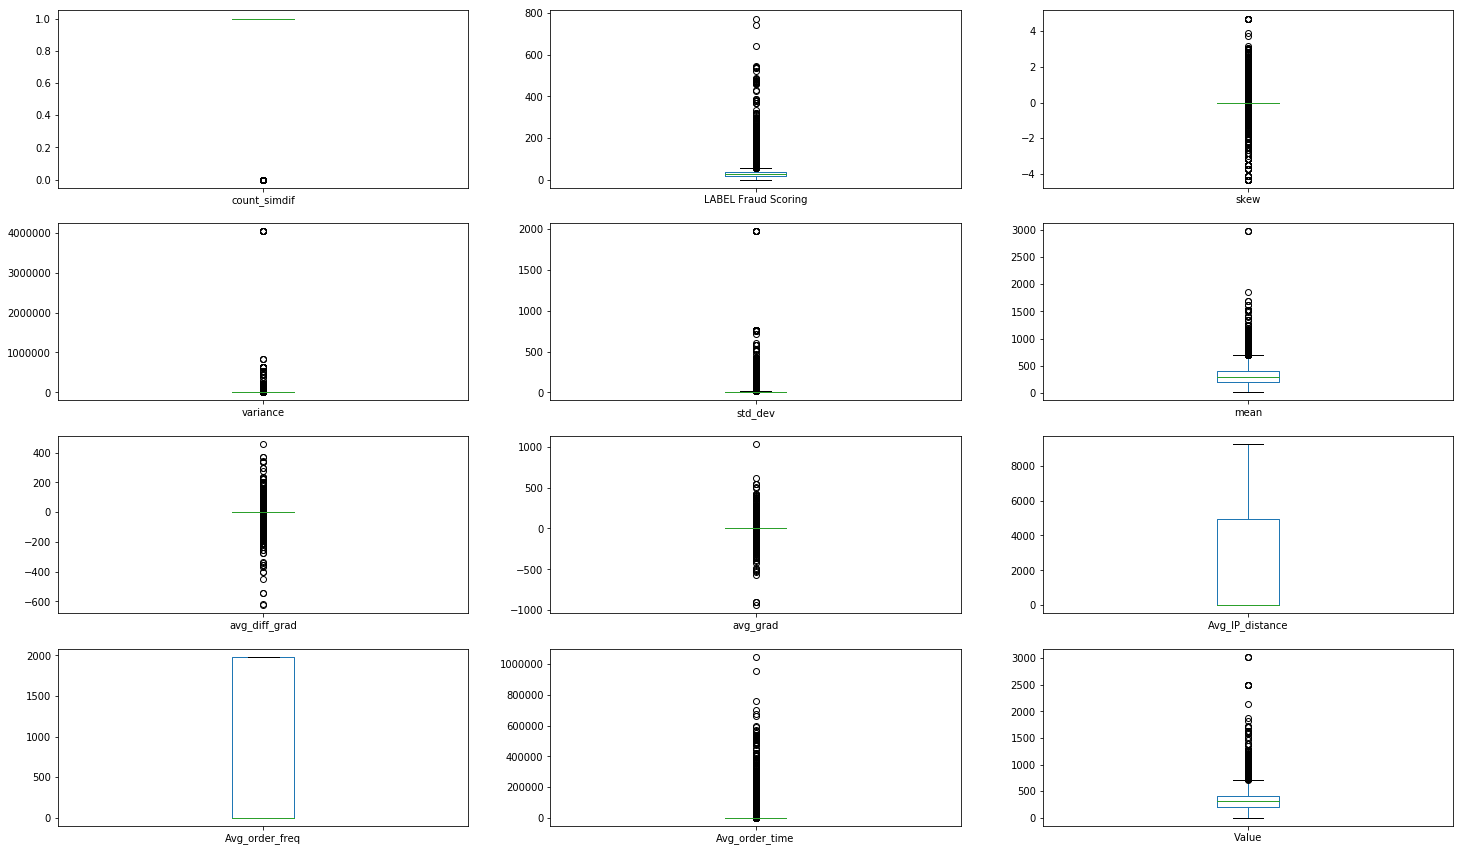

In [78]:
# boxplot of every continuous variable
fig, ax = plt.subplots(4,3, figsize=(25,15))
cols = data.select_dtypes(include=['number']).columns.tolist()
for i in range(0,4):
    for j in range(0,3):
        if cols == []:
            break
        cc = cols[::-1]
        data[cc[0]].plot.box(ax=ax[i,j])
        cols.pop()

looking at the distributions, it could be interesting to apply a log or cox-box transformations on certain features. let's explore that

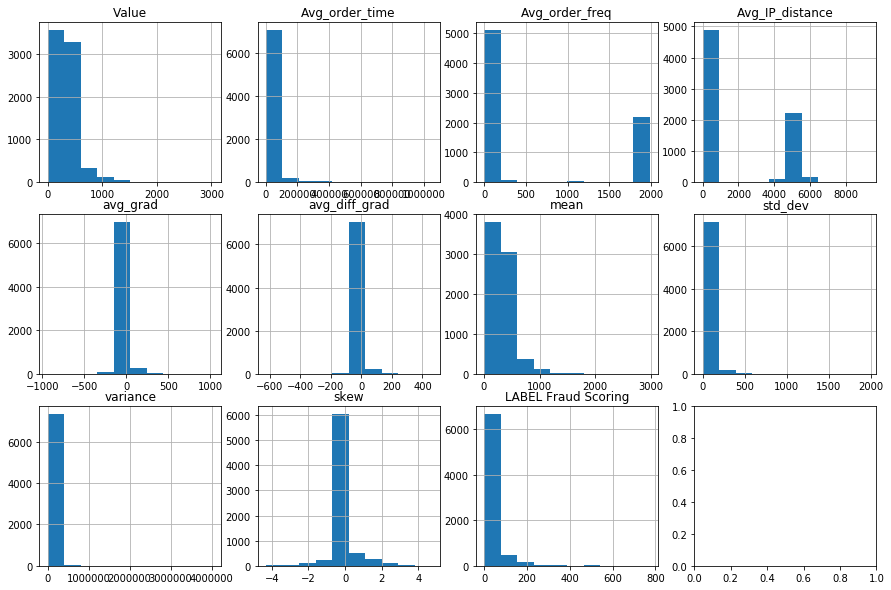

In [79]:
# Histograms
fig, ax = plt.subplots(3,4, figsize=(15,10))
axs = [(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3),(2,0),(2,1),(2,2)]
for i,j in zip(data.select_dtypes(include=['number']).columns, axs):
    data[i].hist(ax=ax[j[0],j[1]])
    ax[j[0],j[1]].set_title(i)

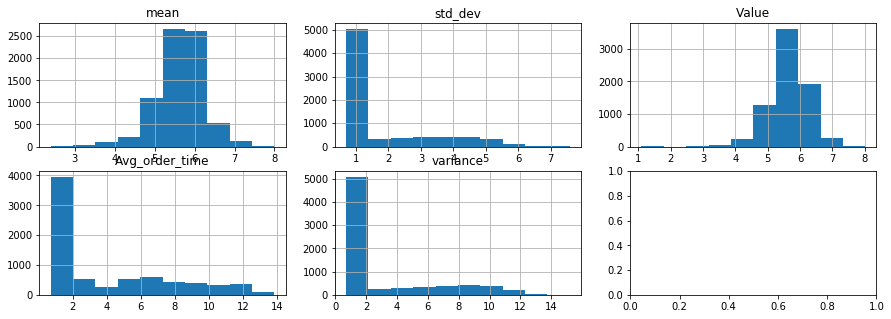

In [80]:
# Log histogram plot
fig, ax = plt.subplots(2,3, figsize=(15,5))
axs = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
for i,j in zip(['mean','std_dev','Value','Avg_order_time','variance'], axs):
    try:
        data[i].apply(lambda x: np.log(x+2)).hist(ax=ax[j[0],j[1]])
        ax[j[0],j[1]].set_title(i)
    except:
        print(i)


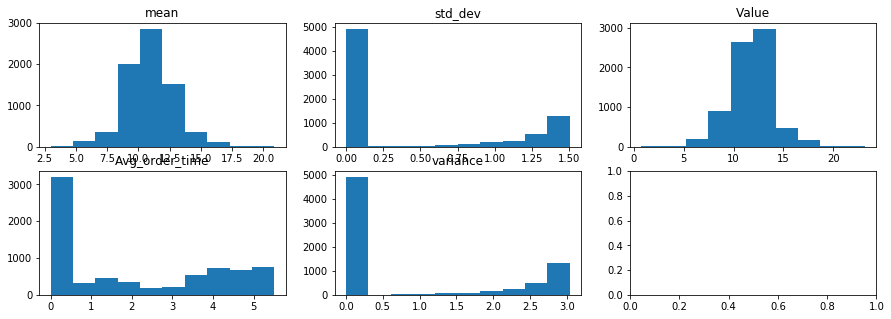

In [81]:
# boxcox histogram plot
fig, ax = plt.subplots(2,3, figsize=(15,5))
axs = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
for i,j in zip(['mean','std_dev','Value','Avg_order_time','variance'], axs):
    try:
        ax[j[0],j[1]].hist(stats.boxcox(data[i]+1)[0])
        ax[j[0],j[1]].set_title(i)
    except:
        print(i)

The boxcox transformation shows good results especially for the "mean" and "Value" that have a normal distribution. we proceed by applying the boxcox transformation

In [82]:
for col in ['mean','std_dev','Value','Avg_order_time','variance']:
    data['boxcox_'+col] = stats.boxcox(data[col]+1)[0]


In [83]:
databis = data.drop(['mean','std_dev','Value','Avg_order_time','variance'], axis=1)

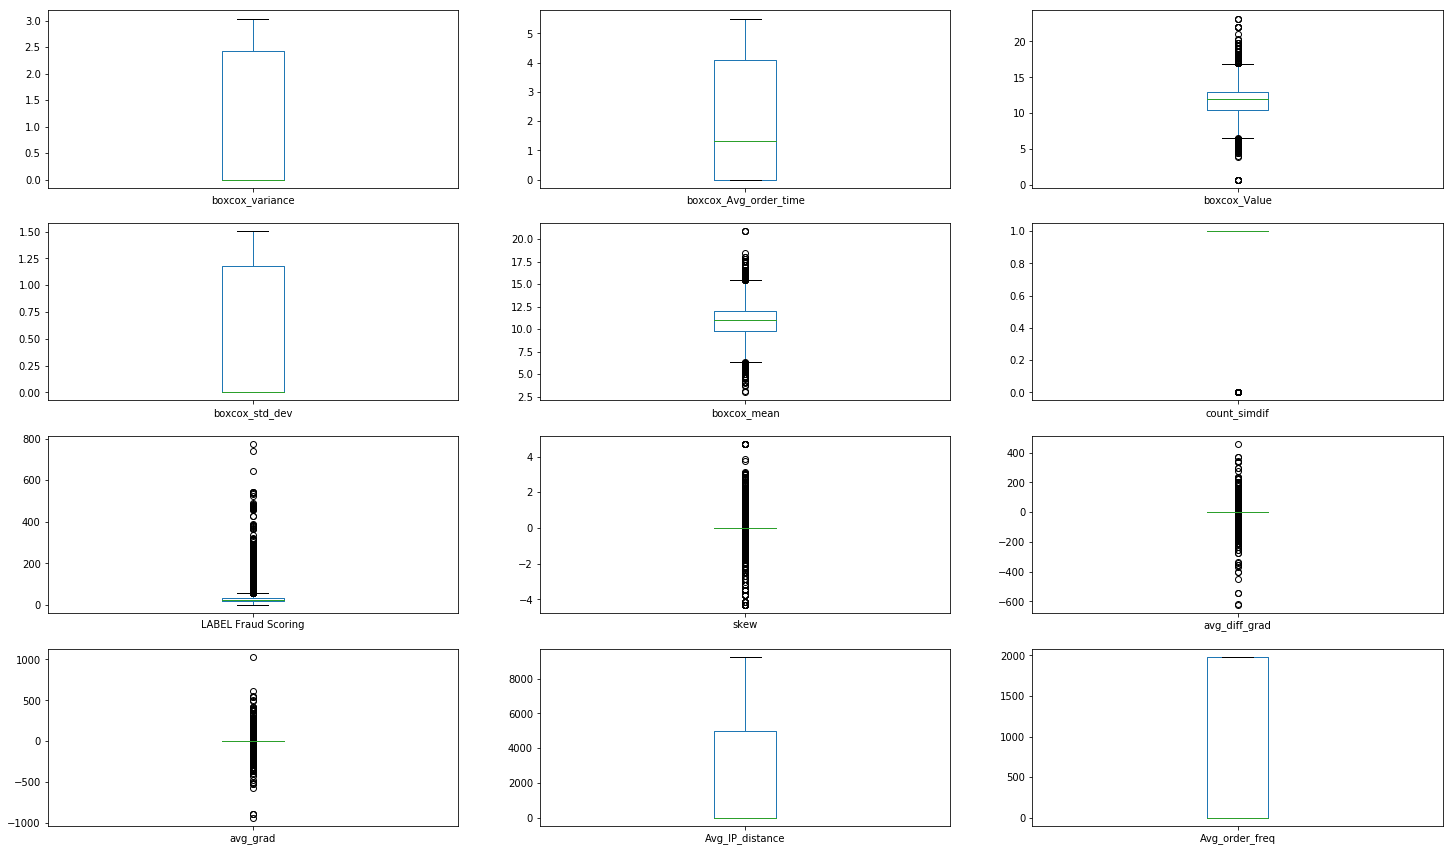

In [84]:
# boxplot of continous variables with new transformations
fig, ax = plt.subplots(4,3, figsize=(25,15))
cols = databis.select_dtypes(include=['number']).columns.tolist()
for i in range(0,4):
    for j in range(0,3):
        if cols == []:
            break
        cc = cols[::-1]
        data[cc[0]].plot.box(ax=ax[i,j])
        cols.pop()

### Multivariate analysis

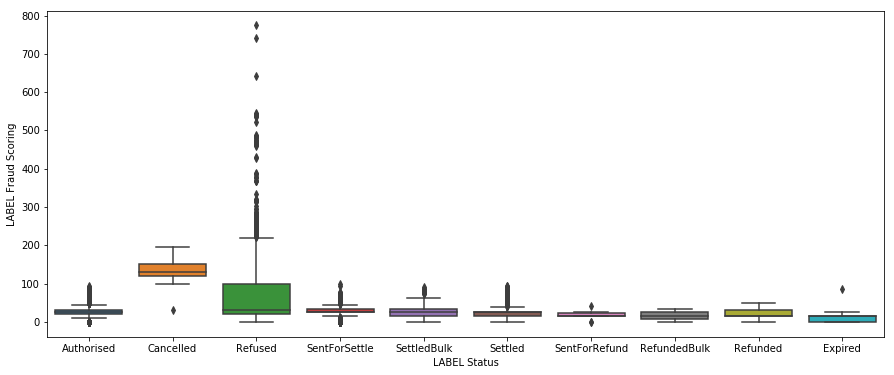

In [85]:
# boxplot of Label Status against Label Fraud Scoring
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(data=databis, x='LABEL Status', y='LABEL Fraud Scoring',ax=ax)

In [86]:
# it seems that there is a threshold of scoring where every value above it is Refused
databis[data['LABEL Fraud Scoring'] >= 200]['LABEL Status'].value_counts()

Refused    123
Name: LABEL Status, dtype: int64

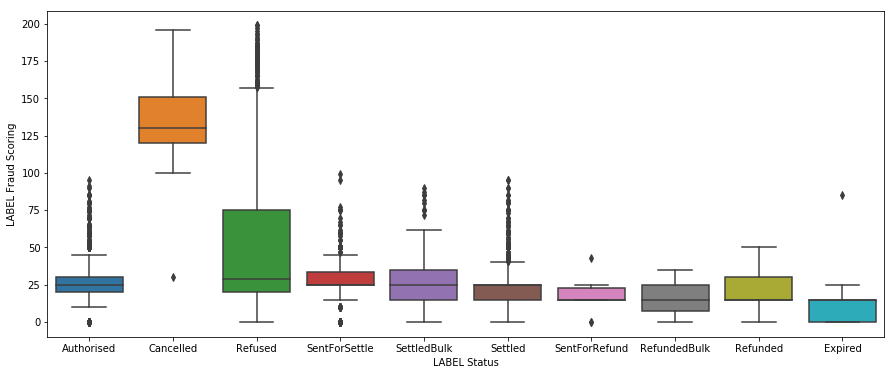

In [87]:
# boxplot of Label Status against Label Fraud Scoring where Label Fraud Scoring is less than 200
# The Label "Cancel" seems to have a distribution different from other status. The Scoring variable doesn't explain everything, let's explore mmore
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(data=databis[data['LABEL Fraud Scoring'] < 200], x='LABEL Status', y='LABEL Fraud Scoring',ax=ax)

In [88]:
# next we explore the relationship between every categorical variable with "Label Status" and "Label Fraud Scoring"
cols = databis.select_dtypes(exclude=['number']).columns.tolist()

In [89]:
cols.remove('LABEL Status')

In [90]:
databis[(databis['Payment Method'] == 'unknowncard')]['LABEL Status'].value_counts()

Refused    76
Name: LABEL Status, dtype: int64

In [91]:
databis[(databis['Payment Method'] == 'unknowncard')&(databis['3D Authenticated']=='N')]['LABEL Status'].value_counts()

Series([], Name: LABEL Status, dtype: int64)

In [92]:
databis[(databis['Payment Method'] == 'directEbanking')]['LABEL Status'].value_counts()

Settled          21
SentForSettle    13
Name: LABEL Status, dtype: int64

In [93]:
databis[(databis['3D Authenticated']=='U')]['LABEL Status'].value_counts()

Refused          654
Cancelled         38
Settled           21
SentForSettle     13
Name: LABEL Status, dtype: int64

In [94]:
databis[(databis['3D Offered']=='U')]['LABEL Status'].value_counts()

Refused          602
Settled           21
SentForSettle     13
Cancelled          1
Name: LABEL Status, dtype: int64

In [95]:
704/databis['LABEL Status'].value_counts()[1]

0.35645569620253165

Obs: 
- The Not 3D Authenticated cases are all refused (704 cases which is 35% of total Refused class) within a 0-99 Label Fraud Scoring, this could be a good feature to differenciate between refused class and others in low Fraud Scoring range

- The "U" category for 3D Offered and 3D Authenticated shows a majority of Refused Status, it could be interesting if there is another variable to differenciate between other present variables

- The unknown category for "payment method" has only Refused Status, this will help furthere. In addition, the "directebanking" seems to have strong relationship with Settled status


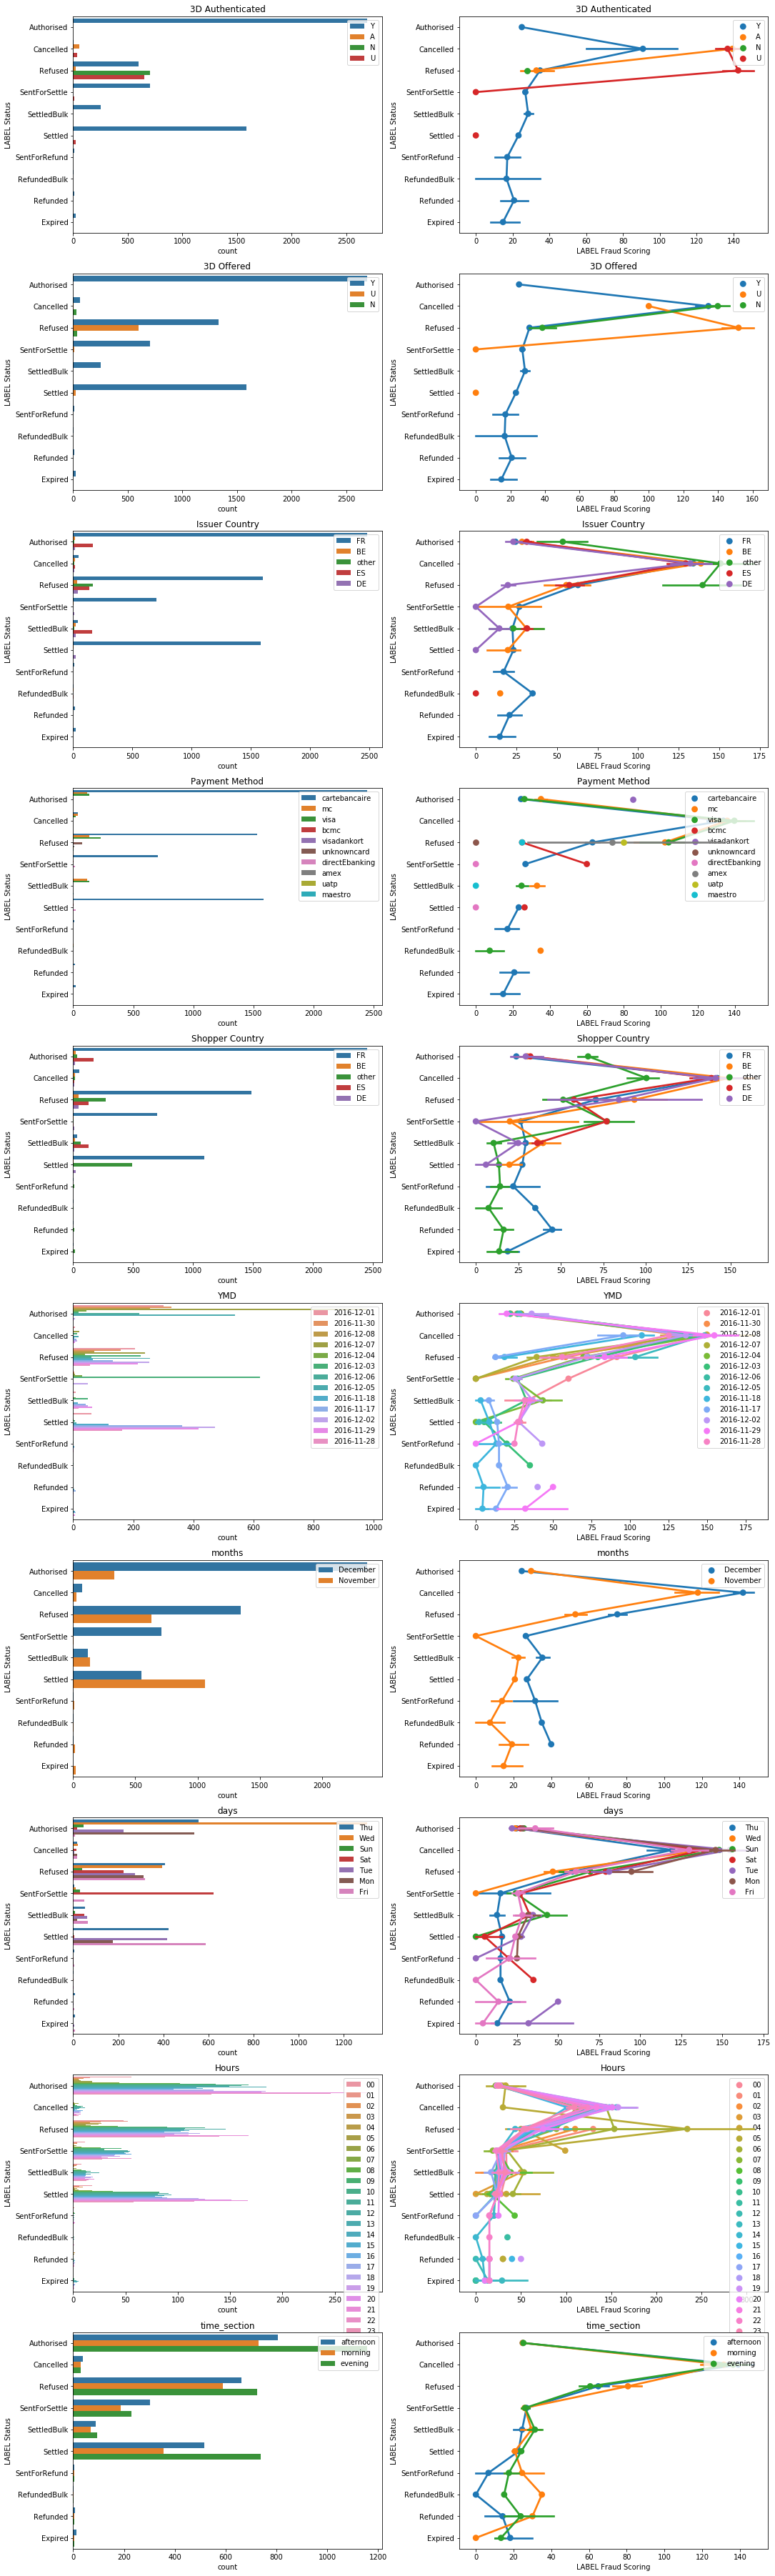

In [96]:
fig, ax = plt.subplots(10,2, figsize=(15,50))
for i,col in enumerate(cols):
    sns.countplot(data=databis, y='LABEL Status',hue=col, orient='h',ax=ax[i,0])
    sns.pointplot(data=databis, x ='LABEL Fraud Scoring' ,y='LABEL Status',hue=col, orient='h',ax=ax[i,1])
    ax[i,1].legend(loc='upper right')
    ax[i,0].legend(loc='upper right')
    ax[i,0].set_title(col)
    ax[i,1].set_title(col)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [97]:
t = databis.pivot_table(index=['LABEL Status'],columns='months', values='LABEL Fraud Scoring')

In [98]:
t['diff'] = t['December']-t['November']

In [99]:
dii = {}
for i,j in enumerate(t['diff']):
    dii[t['diff'].index[i]] = j

In [100]:
def pot(x):
    return dii[x]

In [101]:
#pd.get_dummies(databis['LABEL Status'].apply(pot))

In [102]:
# next we explore the relationship between every continuous variable with "Label Status" and "Label Fraud Scoring"
cols = databis.select_dtypes(include=['number']).columns.tolist()

In [103]:
cols.remove('LABEL Fraud Scoring')

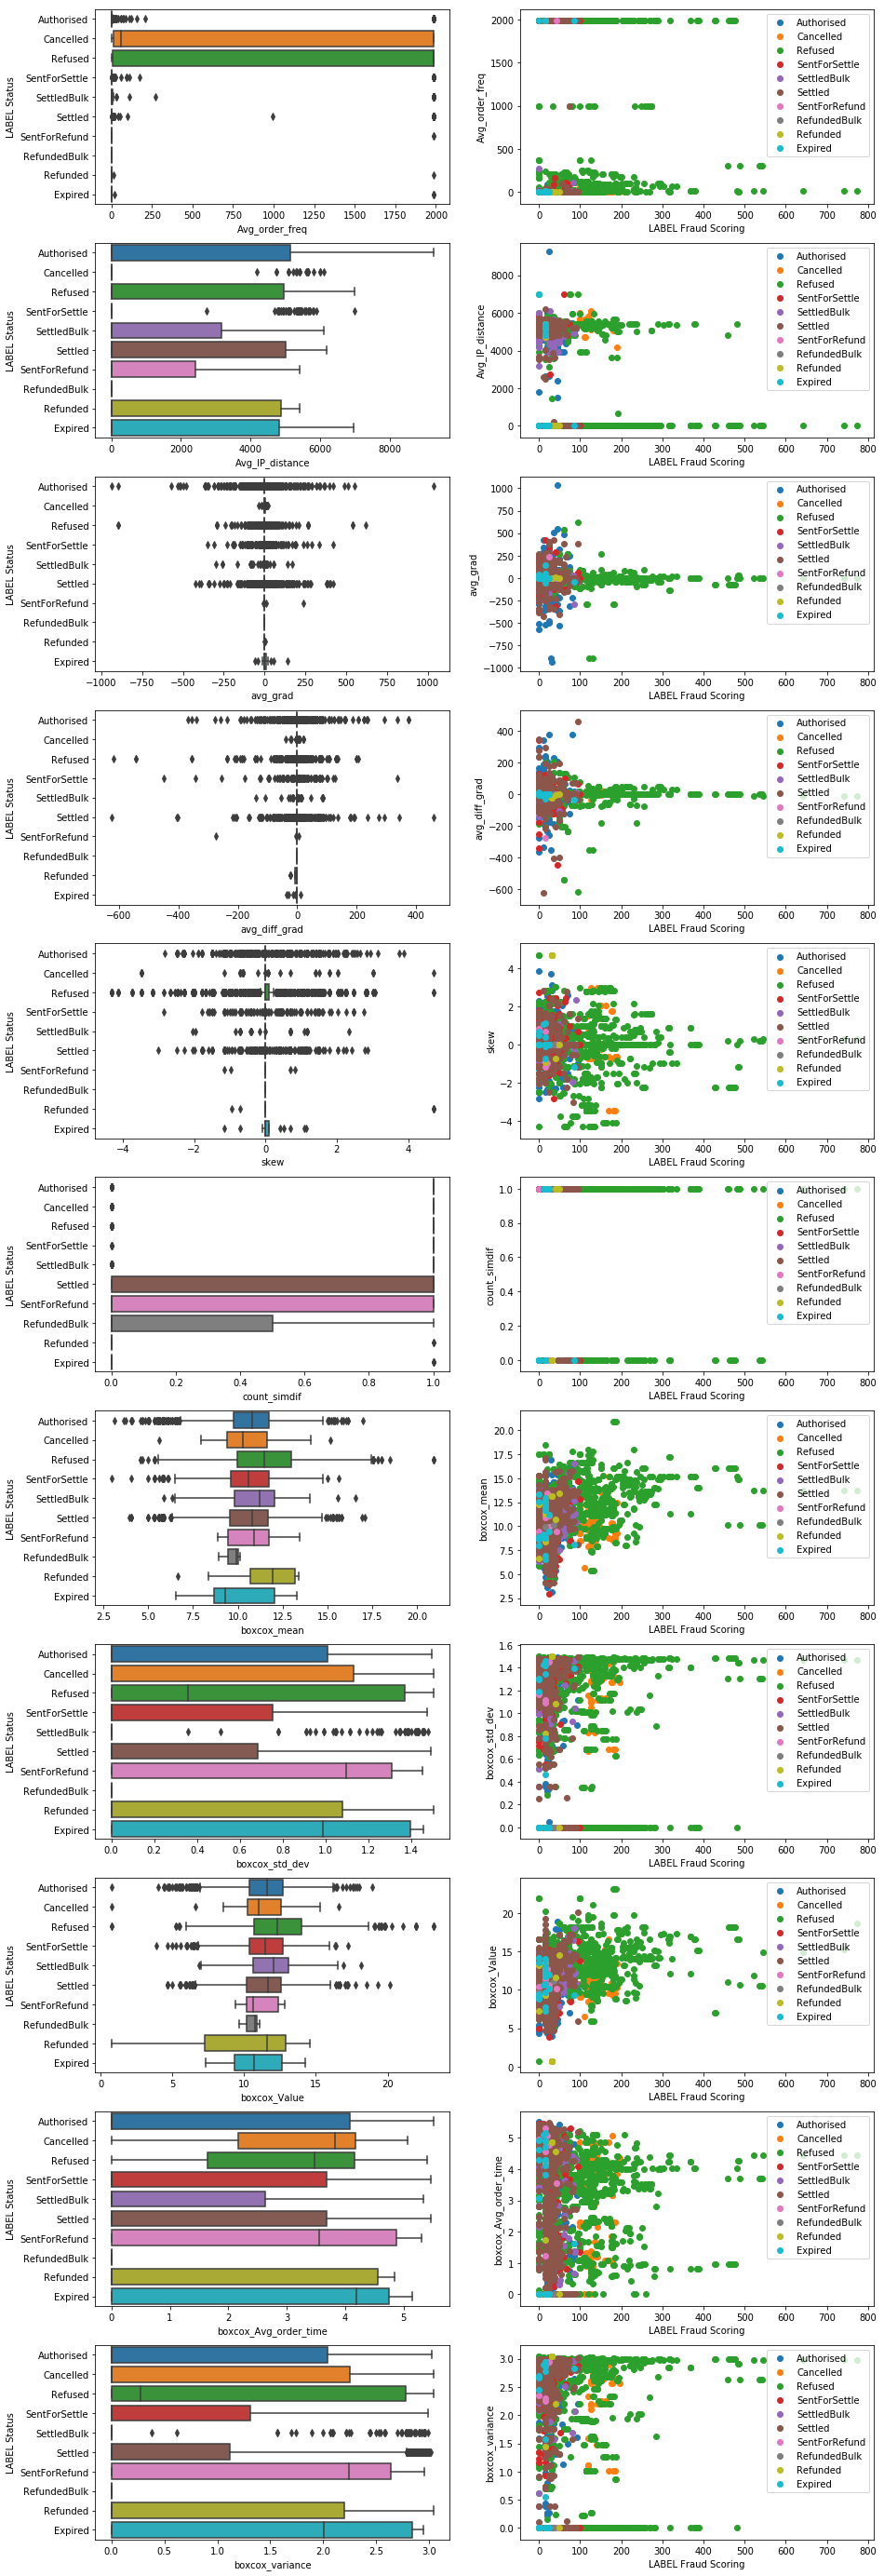

In [104]:
fig, ax = plt.subplots(11,2, figsize=(15,50))
for i,col in enumerate(cols):
    sns.boxplot(data=databis, y='LABEL Status',x=col, orient='h',ax=ax[i,0])
    for j in databis['LABEL Status'].unique():
        try:
            ax[i,1].scatter(databis['LABEL Fraud Scoring'][databis['LABEL Status']==j] , y= databis[col][databis['LABEL Status']==j], label=j)
        except:
            continue
    ax[i,1].set_xlabel('LABEL Fraud Scoring')
    ax[i,1].set_ylabel(col)
    ax[i,1].legend(loc='upper right')


In [105]:
cols = databis.select_dtypes(exclude=['number']).columns.tolist()
cols.remove('LABEL Status')

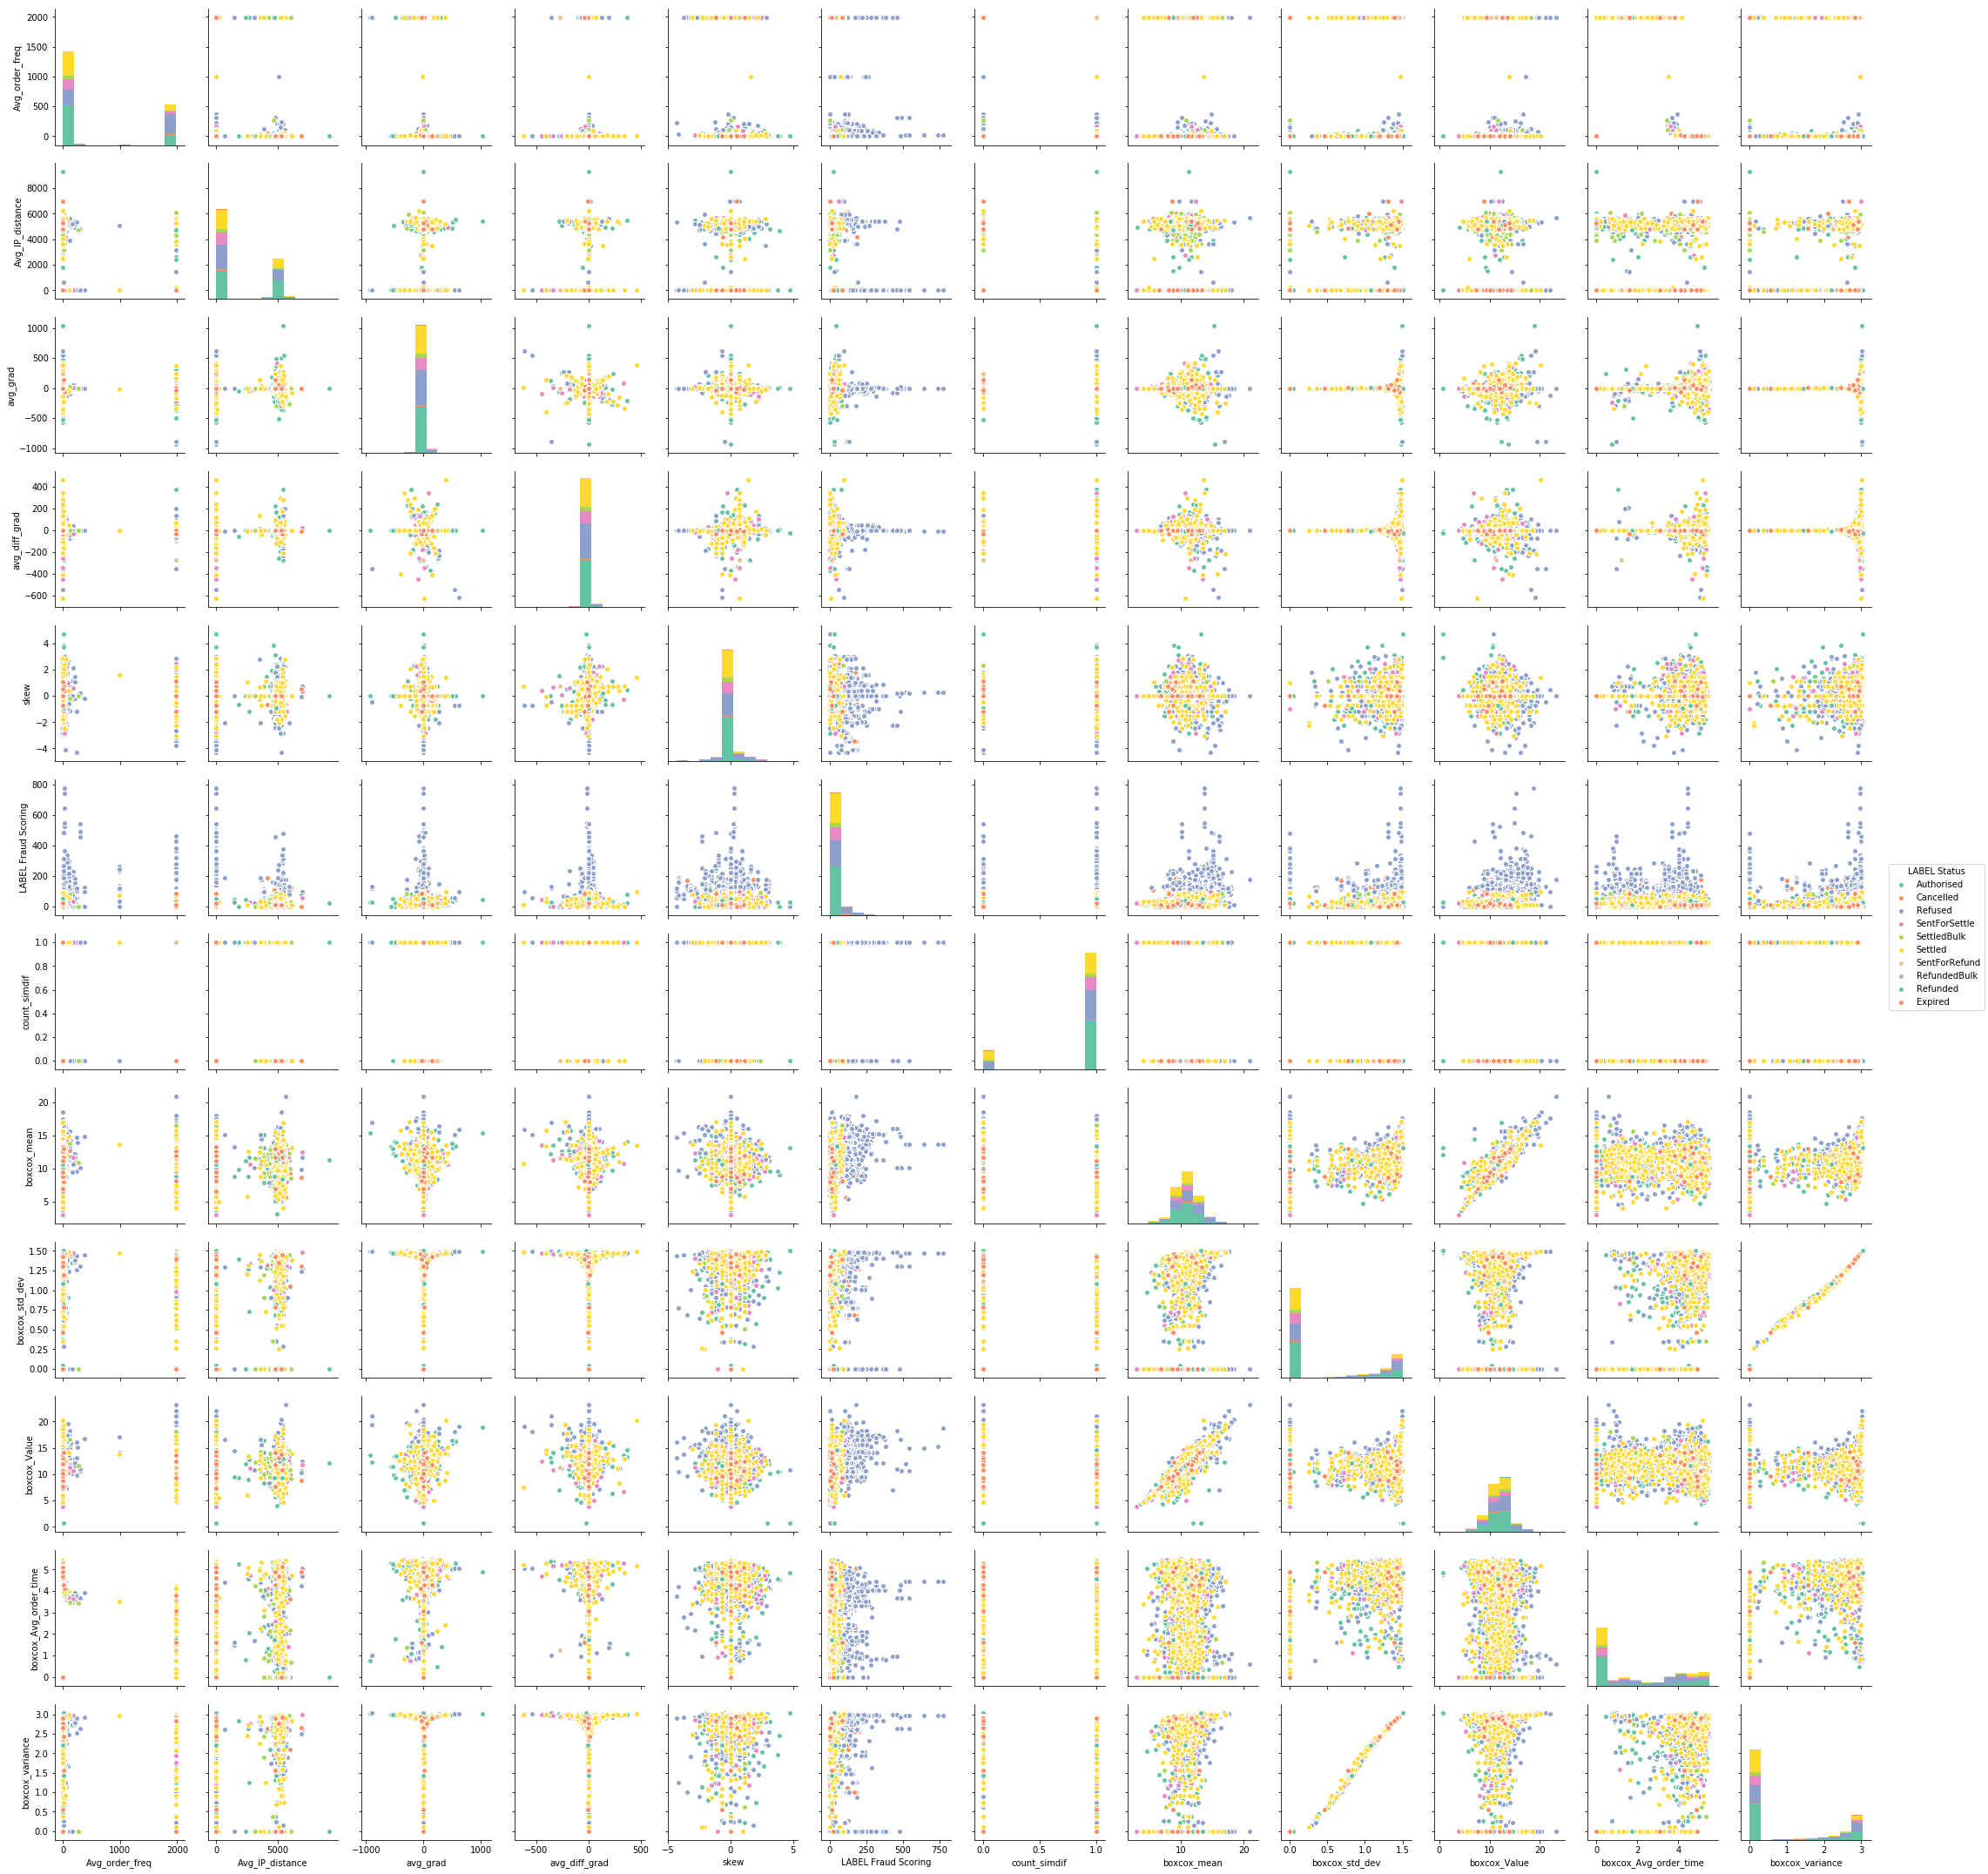

In [106]:
# There is colinearity between "Mean" and "Value", "Std" and "Variance", we will drop "Value" and "Variance"
sns.pairplot(databis.drop(cols,axis=1), kind="scatter", hue="LABEL Status", palette="Set2")

### Modeling

In this excerise, it has been given "LABEL Fraud Scoring" and "LABEL Status" as the targets variables. There are few ways to that we can use to approach the problem, we will list:

- Turn the problem to be a regression such that we predict "LABEL Fraud Scoring" then use the predicted scores to perform classification for "LABEL Status"

- No need to predict "LABEL Fraud Scoring", rather use it (or not) as an independent variable to classify "LABEL Status"

We will proceed with the second approach where we will use the "LABEL Fraud Scoring" as an independent variable. Additionally, we will perform the classifications using two appraoches: 1) drop "LABEL Fraud Scoring, 2) use "LABEL Fraud Scoring". Doing this it will give us information about prediction power of "LABEL Fraud Scoring" which may tell us if this variable does it job explaining the fraud or not.

Moreover, we will group the Classes into "Fraud" and "Not Fraud"

#### Suggested implementation

In this excercise there is a class unbalance, with some extreme values for several independent variables. To solve this problem we suggest the following:

- Algorithms : Adaboost on DecisionTreeClassifier
- Method : Undersampling
- Metrics : Recall, TP, TN
- Features selection

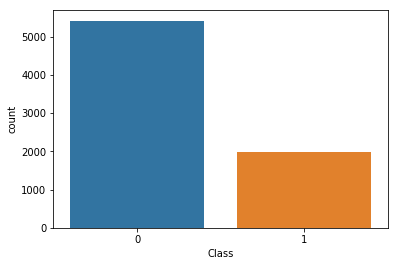

In [107]:
# group classes
data['Class'] = data['LABEL Status'].apply(lambda x: 1 if x == 'Refused' else 0 )
sns.countplot(x=data['Class'])

#### Droping "LABEL Fraud Scoring"

In [108]:
databis.head()

,3D Authenticated,3D Offered,Issuer Country,Payment Method,Shopper Country,Avg_order_freq,Avg_IP_distance,avg_grad,avg_diff_grad,skew,...,months,days,Hours,time_section,count_simdif,boxcox_mean,boxcox_std_dev,boxcox_Value,boxcox_Avg_order_time,boxcox_variance
0,Y,Y,FR,cartebancaire,FR,0.0,5382.179047,0.000000,0.0,0.00000,...,December,Thu,16,afternoon,1,10.581639,0.000000,11.617818,0.000000,0.000000
1,A,Y,BE,mc,BE,46.0,4176.131101,1.869565,0.0,-0.63901,...,December,Thu,16,afternoon,1,9.250998,1.313912,10.355021,4.122513,2.641366
2,Y,Y,other,visa,other,0.0,0.000000,0.000000,0.0,0.00000,...,December,Thu,16,afternoon,1,9.404415,0.000000,10.108454,0.000000,0.000000
3,Y,Y,FR,cartebancaire,FR,0.0,0.000000,0.000000,0.0,0.00000,...,December,Thu,16,afternoon,1,11.139246,0.000000,11.971549,0.000000,0.000000
4,Y,Y,FR,cartebancaire,FR,0.0,0.000000,0.000000,0.0,0.00000,...,December,Thu,16,afternoon,1,8.496981,0.000000,9.141708,0.000000,0.000000


In [109]:
data_drop = pd.concat([databis.select_dtypes(include=['number']).drop(['boxcox_Value','boxcox_variance','LABEL Fraud Scoring'], axis=1),df_cat, data['Class']],axis=1)
data_keep = pd.concat([databis.select_dtypes(include=['number']).drop(['boxcox_Value','boxcox_variance'], axis=1),df_cat, data['Class']],axis=1)

In [110]:
data_drop.columns

Index(['Avg_order_freq', 'Avg_IP_distance', 'avg_grad', 'avg_diff_grad',
       'skew', 'count_simdif', 'boxcox_mean', 'boxcox_std_dev',
       'boxcox_Avg_order_time', '3D Authenticated_A', '3D Authenticated_N',
       '3D Authenticated_U', '3D Offered_N', '3D Offered_U',
       'Issuer Country_BE', 'Issuer Country_DE', 'Issuer Country_ES',
       'Issuer Country_FR', 'Payment Method_amex', 'Payment Method_bcmc',
       'Payment Method_cartebancaire', 'Payment Method_directEbanking',
       'Payment Method_maestro', 'Payment Method_mc', 'Payment Method_uatp',
       'Payment Method_unknowncard', 'Payment Method_visa',
       'Shopper Country_BE', 'Shopper Country_DE', 'Shopper Country_ES',
       'Shopper Country_FR', 'YMD_2016-11-17', 'YMD_2016-11-18',
       'YMD_2016-11-28', 'YMD_2016-11-29', 'YMD_2016-11-30', 'YMD_2016-12-01',
       'YMD_2016-12-02', 'YMD_2016-12-03', 'YMD_2016-12-04', 'YMD_2016-12-05',
       'YMD_2016-12-06', 'YMD_2016-12-07', 'months_December', 'days_Fri',
   

In [111]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black") # color text with white if the value is greater than half the number of maximum number of True or Negative cases

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
def classification_setup(df_data):
    '''Returns X_data, y_data, ls_features'''
    X_data, y_data = df_data, df_data['Class']
    ls_features = list(X_data.keys())
    class_index = ls_features.index('Class')
    ls_features.pop(class_index)
    return X_data, y_data, ls_features

X_data, y_data, ls_features = classification_setup(data_drop)

In [112]:
recall_dict = {} # a dictionary to collect different recall scores

In [113]:
# No udersample
def adaboost_no_undersample(X_data, y_data,plot_confusion, report=False, recall=False):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data)
    dt_clf = DecisionTreeClassifier(max_depth = 1)
    ada_real = AdaBoostClassifier(base_estimator = dt_clf, 
                                  learning_rate = 0.1, 
                                  n_estimators = 100)
    ada_real.fit(X_train[ls_features], y_train)
    y_pred = ada_real.predict(X_test[ls_features])
    test_conf = confusion_matrix(y_test, y_pred)
    if plot_confusion:
        plot_confusion_matrix(test_conf, classes = ['Not Fraud', 'Fraud'])
    if report:
        print(classification_report(y_test,y_pred))
    if recall:
        return recall_score(y_test,y_pred)


             precision    recall  f1-score   support

          0       0.91      0.98      0.95      1359
          1       0.94      0.73      0.82       489

avg / total       0.92      0.92      0.91      1848



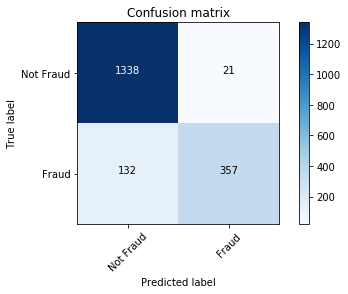

In [114]:
recall_dict['no_undersample'] = adaboost_no_undersample(X_data, y_data, plot_confusion=True, report=True, recall=True)

In [115]:
def under_sample_kfold(X_data, y_data, n_folds = 10):
    '''Returns list of 10 (default) folds of
    X_train, X_test, y_train, y_test data'''
    
    pos_events = X_data[X_data['Class'] == 1]
    neg_events = X_data[X_data['Class'] == 0]
    
    #Randomize and pick same n number of events
    number_pos_events = len(pos_events)  
    undersampled_folds = []

    for fold in range(0, n_folds):
        pos_events = pos_events.reindex(np.random.permutation(pos_events.index))
        neg_events = neg_events.reindex(np.random.permutation(neg_events.index))
        undersampled_events = pd.concat([neg_events.head(number_pos_events), pos_events])
        X_data_u, y_data_u = undersampled_events, undersampled_events['Class']
        X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_data_u, y_data_u, test_size=0.3)
        undersampled_folds.append([X_train_u, X_test_u, y_train_u, y_test_u])
    return undersampled_folds


folds = under_sample_kfold(X_data, y_data)

In [116]:
def adaboost_undersample(folds, full_test_set = False, plot_confusion=True, report=False, recall=False):
    
    for fold in folds:
        X_train, X_test, y_train, y_test = fold[0], fold[1], fold[2], fold[3]
    
        dt_clf = DecisionTreeClassifier(max_depth = 1)
        ada_real = AdaBoostClassifier(base_estimator = dt_clf, 
                                      learning_rate = 0.1, 
                                      n_estimators = 100)
        ada_real.fit(X_train[ls_features], y_train)

        if full_test_set:
            X_train_and_test = pd.concat([X_train, X_data])
            X_test_full = (X_train_and_test.reset_index()
                                           .drop_duplicates(subset= 'index', keep= False)
                                           .set_index('index'))
            y_test_full = X_test_full['Class']
        
            #Eval
            y_pred = ada_real.predict(X_test_full[ls_features])
            test_conf = confusion_matrix(y_test_full, y_pred)
            if plot_confusion:
                plot_confusion_matrix(test_conf, classes = ['Not Fraud', 'Fraud'])
            if report:
                print(classification_report(y_test_full, y_pred))
            if recall:
                return recall_score(y_test_full, y_pred)

    
        else:
            y_pred = ada_real.predict(X_test[ls_features])
            test_conf = confusion_matrix(y_test, y_pred)
            if plot_confusion:
                plot_confusion_matrix(test_conf, classes = ['Not Fraud', 'Fraud'])
            if report:
                print(classification_report(y_test, y_pred))
            if recall:
                return recall_score(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.81      0.96      0.88       588
          1       0.96      0.78      0.86       597

avg / total       0.88      0.87      0.87      1185



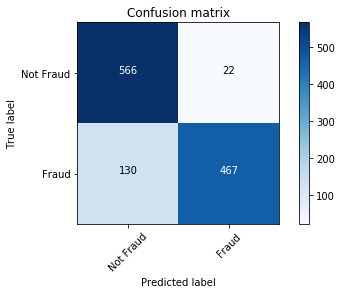

In [117]:
# check score for one fold
recall_dict['onefold_undersample'] = adaboost_undersample([folds[0]], report=True, recall=True)

             precision    recall  f1-score   support

          0       0.97      0.96      0.96      4028
          1       0.72      0.78      0.75       597

avg / total       0.94      0.93      0.93      4625



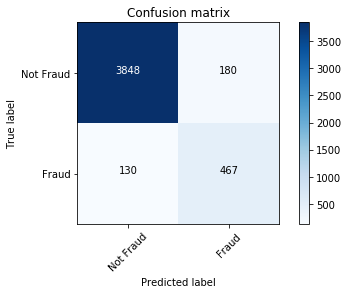

In [118]:
# check score for full test
recall_dict['fulltest_undersample'] = adaboost_undersample([folds[0]], full_test_set = True, report=True, recall=True)

In [119]:
def cv_setup(X_data, y_data):
    '''Returns X_data, y_data, X_cv, y_cv, ls_features
    X_cv, y_cv are randomized 10% of data with same class
    proportions'''
    pos_events = X_data[X_data['Class'] == 1]
    neg_events = X_data[X_data['Class'] == 0]
    number_pos_events, number_neg_events, number_events = (len(pos_events), 
                                                           len(neg_events),
                                                           len(X_data))
    pos_events = pos_events.reindex(np.random.permutation(pos_events.index))
    neg_events = neg_events.reindex(np.random.permutation(neg_events.index))
    X_cv = pd.concat([neg_events.tail(number_neg_events//10), 
                      pos_events.tail(number_pos_events//10)])
    y_cv = X_cv['Class']

    #Get rid of duplicates between CV and Test/Train bank of data
    X_data = pd.concat([X_cv, X_data])
    X_data = (X_data.reset_index()
                    .drop_duplicates(subset= 'index', keep= False)
                    .set_index('index'))
    y_data = X_data['Class']
    
    return X_data, y_data, X_cv, y_cv, ls_features

In [120]:
#Remake our folds without including 10% of the data for a CV set
X_data, y_data, X_cv, y_cv, ls_features = cv_setup(X_data, y_data)
folds = under_sample_kfold(X_data, y_data)

In [121]:
def adaboost_undersample_ensemble(folds, cutoff, e_cutoff,plot_confusion=True, report=False, metric=False):
    
    X_train_all_folds = pd.DataFrame()
    ada_ensemble = []
    
    for fold in folds:
        X_train, X_test, y_train, y_test = fold[0], fold[1], fold[2], fold[3]
    
        dt_clf = DecisionTreeClassifier(max_depth = 1)
        ada_real = AdaBoostClassifier(base_estimator = dt_clf, 
                                      learning_rate = 0.1, 
                                      n_estimators = 100)
        ada_real.fit(X_train[ls_features], y_train)
        #Concatenate all train sets and store each fold models
        X_train_all_folds = pd.concat([X_train_all_folds, X_train])
        ada_ensemble.append(ada_real)
    
    #Call scorer
    recall = ensemble_score(X_cv, y_cv, ada_ensemble, plot_confusion, report, metric,cutoff, e_cutoff)
    return recall

def ensemble_score(X_test, y_test, models, plot_confusion, report, metric, cutoff, e_cutoff):
    '''Prints confusion matrix for an ensemble of models based on 
    probability cutoff (cutoff) of each model and voting cutoff 
    (e_cutoff) for an ensemble vote. Default is >50% probability
    and > 5 votes out of 10'''
    
    for fold in range(0, len(models)):
        X_test.loc[:, ('Prob fold ' + str(fold))] = models[fold].predict_proba(X_test[ls_features])[:,1]
        X_test.loc[:, ('ADAPred fold ' + str(fold))] = (X_test[('Prob fold ' + str(fold))] >= cutoff).astype(int)
    
    X_test.loc[:, 'Ensemble Score'] = X_test[['ADAPred fold ' + str(i) for i in range(0, len(models))]].sum(axis = 1)
    X_test.loc[:, 'Ensemble Pred'] = (X_test['Ensemble Score'] > e_cutoff).astype(int)

    ensemble_conf = confusion_matrix(y_test, X_test[('Ensemble Pred')])
    if plot_confusion:
        plot_confusion_matrix(ensemble_conf, classes = ['Not Fraud', 'Fraud'])
    if report:
        print(classification_report(y_test,X_test[('Ensemble Pred')]))
    if metric == 'recall_1':
        return ensemble_conf[1,1]/(ensemble_conf[1,0]+ensemble_conf[1,1])
    elif metric == 'recall_0':
        return ensemble_conf[0,1]/(ensemble_conf[0,1]+ensemble_conf[0,0])
    elif metric == 'both':
        return ensemble_conf[0,1]/(ensemble_conf[0,1]+ensemble_conf[0,0]), ensemble_conf[1,1]/(ensemble_conf[1,0]+ensemble_conf[1,1])
        

             precision    recall  f1-score   support

          0       0.93      0.97      0.95       541
          1       0.92      0.80      0.86       197

avg / total       0.93      0.93      0.93       738



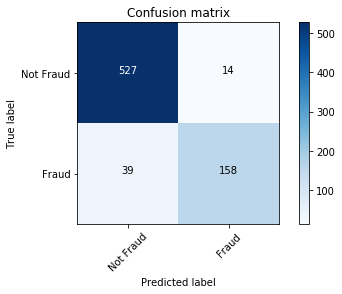

In [122]:
recall_dict['undersample_ensemble'] = adaboost_undersample_ensemble(folds, report=True, metric='recall', cutoff=0.5, e_cutoff=5)

In [123]:
# it is clear that using undersampling and cross val methods improved the performace
recall_dict

{'fulltest_undersample': 0.78224455611390287,
 'no_undersample': 0.73006134969325154,
 'onefold_undersample': 0.78224455611390287,
 'undersample_ensemble': None}

#### Drop "LABEL Fraud Scoring"

             precision    recall  f1-score   support

          0       0.93      0.96      0.94       541
          1       0.89      0.79      0.84       197

avg / total       0.92      0.92      0.92       738



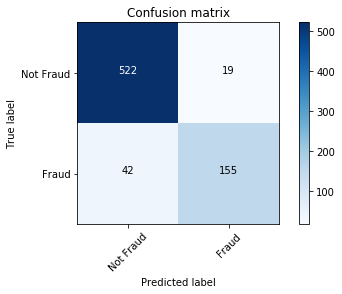

In [124]:
X_data, y_data, ls_features = classification_setup(data_drop)
X_data_cv, y_data_cv, X_cv, y_cv, ls_features = cv_setup(X_data, y_data)
folds = under_sample_kfold(X_data_cv, y_data_cv)
adaboost_undersample_ensemble(folds,report=True, cutoff=0.5, e_cutoff=5)

In [125]:
# explore the best threshold 
cut_off = np.arange(0,1,0.1)

recall_cutoff= {}

for i,j in enumerate(cut_off):
    X_data_cv, y_data_cv, X_cv, y_cv, ls_features = cv_setup(X_data, y_data)
    folds = under_sample_kfold(X_data_cv, y_data_cv)
    recall_cutoff[j] = adaboost_undersample_ensemble(folds,plot_confusion=False,cutoff=j, e_cutoff=5, metric='recall_1')

In [126]:
recall_cutoff

{0.0: 1.0,
 0.10000000000000001: 1.0,
 0.20000000000000001: 1.0,
 0.30000000000000004: 1.0,
 0.40000000000000002: 1.0,
 0.5: 0.79187817258883253,
 0.60000000000000009: 0.62944162436548223,
 0.70000000000000007: 0.28426395939086296,
 0.80000000000000004: 0.0,
 0.90000000000000002: 0.0}

In [127]:
cut_off = np.arange(0.4,0.51,0.01)

recall_cutoff= {}

for i,j in enumerate(cut_off):
    X_data_cv, y_data_cv, X_cv, y_cv, ls_features = cv_setup(X_data, y_data)
    folds = under_sample_kfold(X_data_cv, y_data_cv)
    recall_cutoff[j] = adaboost_undersample_ensemble(folds,plot_confusion=False,cutoff=j, e_cutoff=5, metric='recall_1')

In [128]:
sorted_recall_cutoff = sorted(recall_cutoff.items(), key=lambda x: x[1],reverse=True)
sorted_recall_cutoff

[(0.40000000000000002, 1.0),
 (0.41000000000000003, 1.0),
 (0.45000000000000007, 0.98984771573604058),
 (0.42000000000000004, 0.98477157360406087),
 (0.47000000000000008, 0.98477157360406087),
 (0.46000000000000008, 0.97461928934010156),
 (0.44000000000000006, 0.97461928934010156),
 (0.48000000000000009, 0.95431472081218272),
 (0.43000000000000005, 0.95431472081218272),
 (0.4900000000000001, 0.9441624365482234),
 (0.50000000000000011, 0.79187817258883253)]

In [129]:
for i,j in enumerate(sorted_recall_cutoff):
    print('The classification report for {:.2f}'.format(j[0]))
    X_data_cv, y_data_cv, X_cv, y_cv, ls_features = cv_setup(X_data, y_data)
    folds = under_sample_kfold(X_data_cv, y_data_cv)
    adaboost_undersample_ensemble(folds,plot_confusion=False, report=True, cutoff=j[0], e_cutoff=5)

The classification report for 0.40
             precision    recall  f1-score   support

          0       1.00      0.00      0.01       541
          1       0.27      1.00      0.42       197

avg / total       0.80      0.27      0.12       738

The classification report for 0.41
             precision    recall  f1-score   support

          0       1.00      0.00      0.01       541
          1       0.27      1.00      0.42       197

avg / total       0.80      0.27      0.12       738

The classification report for 0.45
             precision    recall  f1-score   support

          0       0.99      0.62      0.76       541
          1       0.48      0.98      0.65       197

avg / total       0.85      0.71      0.73       738

The classification report for 0.42
             precision    recall  f1-score   support

          0       0.98      0.57      0.72       541
          1       0.45      0.97      0.62       197

avg / total       0.84      0.68      0.69       738



             precision    recall  f1-score   support

          0       0.99      0.69      0.81       541
          1       0.53      0.98      0.69       197

avg / total       0.87      0.76      0.78       738



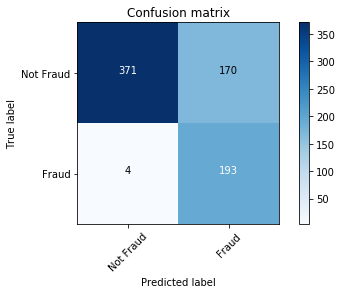

In [130]:
X_data_cv, y_data_cv, X_cv, y_cv, ls_features = cv_setup(X_data, y_data)
folds = under_sample_kfold(X_data_cv, y_data_cv)
adaboost_undersample_ensemble(folds,report=True, cutoff=0.47, e_cutoff=5)

#### Keep "LABEL Faud Scoring"

In [131]:
X_data, y_data, ls_features = classification_setup(data_keep)
cut_off = np.arange(0,1,0.1)

recall_cutoff= {}

for i,j in enumerate(cut_off):
    X_data_cv, y_data_cv, X_cv, y_cv, ls_features = cv_setup(X_data, y_data)
    folds = under_sample_kfold(X_data_cv, y_data_cv)
    recall_cutoff[j] = adaboost_undersample_ensemble(folds,plot_confusion=False,cutoff=j, e_cutoff=5, metric='recall_1')

In [132]:
recall_cutoff

{0.0: 1.0,
 0.10000000000000001: 1.0,
 0.20000000000000001: 1.0,
 0.30000000000000004: 1.0,
 0.40000000000000002: 1.0,
 0.5: 0.7766497461928934,
 0.60000000000000009: 0.61928934010152281,
 0.70000000000000007: 0.30964467005076141,
 0.80000000000000004: 0.0,
 0.90000000000000002: 0.0}

In [133]:
cut_off = np.arange(0.4,0.51,0.01)

recall_cutoff= {}

for i,j in enumerate(cut_off):
    X_data_cv, y_data_cv, X_cv, y_cv, ls_features = cv_setup(X_data, y_data)
    folds = under_sample_kfold(X_data_cv, y_data_cv)
    recall_cutoff[j] = adaboost_undersample_ensemble(folds,plot_confusion=False,cutoff=j, e_cutoff=5, metric='recall_1')

In [134]:
sorted_recall_cutoff = sorted(recall_cutoff.items(), key=lambda x: x[1],reverse=True)
sorted_recall_cutoff

[(0.40000000000000002, 1.0),
 (0.41000000000000003, 1.0),
 (0.44000000000000006, 1.0),
 (0.43000000000000005, 0.98984771573604058),
 (0.42000000000000004, 0.98477157360406087),
 (0.45000000000000007, 0.98477157360406087),
 (0.46000000000000008, 0.97461928934010156),
 (0.47000000000000008, 0.96954314720812185),
 (0.48000000000000009, 0.949238578680203),
 (0.4900000000000001, 0.91370558375634514),
 (0.50000000000000011, 0.80710659898477155)]

In [135]:
for i,j in enumerate(sorted_recall_cutoff):
    print('The classification report for {:.2f}'.format(j[0]))
    X_data_cv, y_data_cv, X_cv, y_cv, ls_features = cv_setup(X_data, y_data)
    folds = under_sample_kfold(X_data_cv, y_data_cv)
    adaboost_undersample_ensemble(folds,plot_confusion=False, report=True, cutoff=j[0], e_cutoff=5)

The classification report for 0.40
             precision    recall  f1-score   support

          0       1.00      0.01      0.01       541
          1       0.27      1.00      0.42       197

avg / total       0.80      0.27      0.12       738

The classification report for 0.41
             precision    recall  f1-score   support

          0       0.95      0.04      0.07       541
          1       0.27      0.99      0.43       197

avg / total       0.77      0.29      0.17       738

The classification report for 0.44
             precision    recall  f1-score   support

          0       0.99      0.59      0.74       541
          1       0.47      0.99      0.64       197

avg / total       0.85      0.70      0.71       738

The classification report for 0.43
             precision    recall  f1-score   support

          0       0.98      0.55      0.70       541
          1       0.44      0.97      0.61       197

avg / total       0.84      0.66      0.68       738



             precision    recall  f1-score   support

          0       0.97      0.75      0.85       541
          1       0.58      0.94      0.72       197

avg / total       0.87      0.80      0.81       738



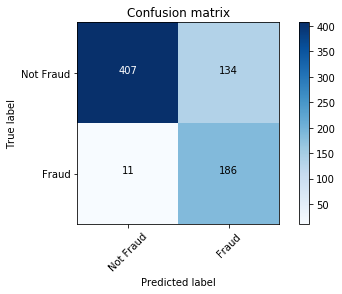

In [136]:
X_data_cv, y_data_cv, X_cv, y_cv, ls_features = cv_setup(X_data, y_data)
folds = under_sample_kfold(X_data_cv, y_data_cv)
adaboost_undersample_ensemble(folds,report=True, cutoff=0.48, e_cutoff=5)

In [137]:
# check the bias and variance of recall
steps = range(100)
epochs = range(10)

recall_scores = []

for step in steps:
    ten_scores = []
    for epoch in epochs:
        try:
            X_data_cv, y_data_cv, X_cv, y_cv, ls_features = cv_setup(X_data, y_data)
            folds = under_sample_kfold(X_data_cv, y_data_cv)
            ten_scores.append(adaboost_undersample_ensemble(folds, plot_confusion=False, cutoff=0.48, e_cutoff=5, metric='recall_1'))
        except:
            continue
    recall_scores.append(np.mean(ten_scores))
    if step%10 == 0:
        print("The average of recall scores is {} with {} of standard deviation".format(np.mean(recall_scores), np.std(recall_scores)))

The average of recall scores is 0.9639593908629444 with 0.0 of standard deviation
The average of recall scores is 0.9592985694508539 with 0.00408287888520437 of standard deviation
The average of recall scores is 0.9601401982112644 with 0.0039494586928692215 of standard deviation
The average of recall scores is 0.9600458490257081 with 0.0038468933476649998 of standard deviation
The average of recall scores is 0.9590689612479881 with 0.004351894135478785 of standard deviation
The average of recall scores is 0.9590126405892307 with 0.004275275803652485 of standard deviation
The average of recall scores is 0.9587417824748273 with 0.004363886476837492 of standard deviation
The average of recall scores is 0.9585472224208194 with 0.004178903323523049 of standard deviation
The average of recall scores is 0.9583944350441812 with 0.004222549682581267 of standard deviation
The average of recall scores is 0.9586712779606181 with 0.004231686989572876 of standard deviation


#### Features selection

In [138]:
X_data, y_data, ls_features = classification_setup(data_keep)
X_data_cv, y_data_cv, X_cv, y_cv, ls_features = cv_setup(X_data, y_data)
folds = under_sample_kfold(X_data_cv, y_data_cv)
pr, re = adaboost_undersample_ensemble(folds,plot_confusion = False, report=False,cutoff=0.48, e_cutoff=5, metric='both')
sel_features = []
sel_pr, sel_re = 0, 0 

In [139]:
cp_features = ls_features[::]

In [141]:
# feature select that removes one feature at a time evaluate the model then compare the result with the baseline
count=0 # counter for stopping
baseline_pr = 0.67 # set a baseline for recall of the 0 class
sel_features = [] # enmpty list of selected features to eliminate
count_em = 0 # this counter is to track if the list of selected features is zero will next reduce the baseline by 0.01
flag = False # this flag activate the count_em and discount the baseline_pr
while count < 100:
    ln = len(ls_features) # len of initial features

    for i in range(ln):
        feature = ls_features[i] # the feature to be removed
        ls_features.remove(ls_features[i])
        folds = under_sample_kfold(X_data_cv, y_data_cv)
        sel_pr, sel_re = adaboost_undersample_ensemble(folds,plot_confusion = False, report=False, cutoff=0.48, e_cutoff=5, metric='both')
        if sel_re >= re and sel_pr >= baseline_pr: # criteria to defintely select the removed feature
            sel_features.append(feature)
            # print(sel_re, feature) for debbuging
            flag=True
            break # break and initialize the list whitout the selected feature
        ls_features.insert(i, feature) # if the criteria is not met, add the feature back to its initial position
    # print(sel_re >= re,(sel_re+sel_pr)/2 >= baseline_pr, sel_features) for debbuging
    
    if not flag and sel_features == []: # if no feature has been selected, discount the baseline by 0.01
        count_em    += 1
        baseline_pr -= 0.01
    
    if count_em ==5 and sel_features == []: # if after 5 discounts there is no selected feature, break 
            break
    
    ls_features= cp_features[::] # initialize the list of features
    
    try:
        for j in sel_features: # remove selected features
            ls_features.remove(j)
        flag = False
    except:
        count += 1




False False []
True False []
False False []
True False []
True False []


In [142]:
# have a list of kept features
ls_features = cp_features[::]
for i in sel_features:
    ls_features.remove(i)

             precision    recall  f1-score   support

          0       0.98      0.70      0.81       541
          1       0.54      0.96      0.69       197

avg / total       0.86      0.77      0.78       738



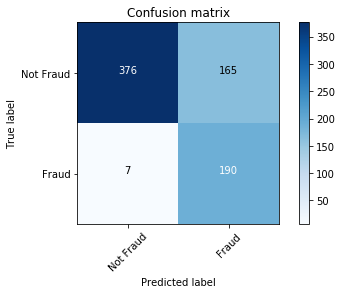

In [143]:
folds = under_sample_kfold(X_data_cv, y_data_cv)
adaboost_undersample_ensemble(folds,report=True, cutoff=0.47, e_cutoff=5)

in this excercise, the challenge of unbalanced classes was handled using undersampling that showed improvement in the performance. It is clear that in such problems like "fraud detection", the most telling metric is Recall, we want to classify all "fraud" classes correctly, otherwise it can be costly. we have seen in this excercise that we managed to keep correct classification of "fraud" classe high, however, there could be a deeper investigation about false positive classes 

#### Suggested improvements:

- Use all classes for Label status 
- Use hypertuning 
- Add more algorithms along with adaboost
- use other types of feature selections such as Ridge, lasso ... etc
- try other combinations for ensemble models to improve the recall
- Use oversampling and compare it with undersampling
